In [ ]:
# Run Date: Friday, June 02, 2023
# Run Time: 00:47:04

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

# 👾 PixelCNN from scratch

In this notebook, we'll walk through the steps required to train your own PixelCNN on the fashion MNIST dataset from scratch

The code has been adapted from the excellent [PixelCNN tutorial](https://keras.io/examples/generative/pixelcnn/) created by ADMoreau, available on the Keras website.

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers, callbacks

from notebooks.utils import display

2023-06-02 18:18:24.297707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 18:18:24.416012: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 4
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, _), (_, _) = datasets.fashion_mnist.load_data()

In [5]:
# Preprocess the data
def preprocess(imgs_int):
    imgs_int = np.expand_dims(imgs_int, -1)
    imgs_int = tf.image.resize(imgs_int, (IMAGE_SIZE, IMAGE_SIZE)).numpy()
    imgs_int = (imgs_int / (256 / PIXEL_LEVELS)).astype(int)
    imgs = imgs_int.astype("float32")
    imgs = imgs / PIXEL_LEVELS
    return imgs, imgs_int


input_data, output_data = preprocess(x_train)

2023-06-02 18:18:26.210277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 18:18:26.210462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 18:18:26.212253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 18:18:26.212404: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-02 18:18:26.212545: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

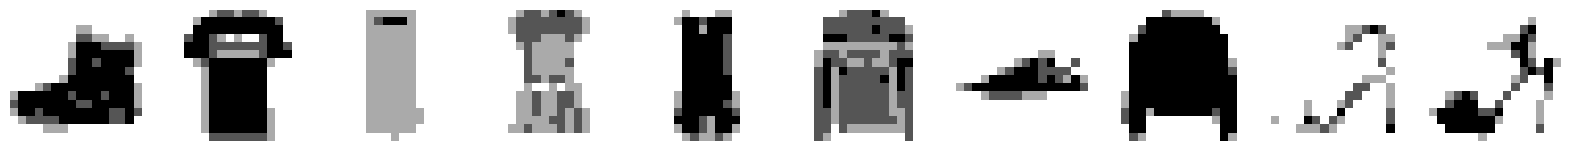

In [6]:
# Show some items of clothing from the training set
display(input_data)

## 2. Build the PixelCNN

In [7]:
# The first layer is the PixelCNN layer. This layer simply
# builds on the 2D convolutional layer, but includes masking.
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, **kwargs):
        super(MaskedConv2D, self).__init__()
        self.mask_type = mask_type
        self.conv = layers.Conv2D(**kwargs)

    def build(self, input_shape):
        # Build the conv2d layer to initialize kernel variables
        self.conv.build(input_shape)
        # Use the initialized kernel to create the mask
        kernel_shape = self.conv.kernel.get_shape()
        self.mask = np.zeros(shape=kernel_shape)
        self.mask[: kernel_shape[0] // 2, ...] = 1.0
        self.mask[kernel_shape[0] // 2, : kernel_shape[1] // 2, ...] = 1.0
        if self.mask_type == "B":
            self.mask[kernel_shape[0] // 2, kernel_shape[1] // 2, ...] = 1.0

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        return self.conv(inputs)

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [8]:
class ResidualBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv2D(
            filters=filters // 2, kernel_size=1, activation="relu"
        )
        self.pixel_conv = MaskedConv2D(
            mask_type="B",
            filters=filters // 2,
            kernel_size=3,
            activation="relu",
            padding="same",
        )
        self.conv2 = layers.Conv2D(
            filters=filters, kernel_size=1, activation="relu"
        )

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pixel_conv(x)
        x = self.conv2(x)
        return layers.add([inputs, x])

    def get_config(self):
        cfg = super().get_config()
        return cfg

In [9]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
x = MaskedConv2D(
    mask_type="A",
    filters=N_FILTERS,
    kernel_size=7,
    activation="relu",
    padding="same",
)(inputs)

for _ in range(RESIDUAL_BLOCKS):
    x = ResidualBlock(filters=N_FILTERS)(x)

for _ in range(2):
    x = MaskedConv2D(
        mask_type="B",
        filters=N_FILTERS,
        kernel_size=1,
        strides=1,
        activation="relu",
        padding="valid",
    )(x)

out = layers.Conv2D(
    filters=PIXEL_LEVELS,
    kernel_size=1,
    strides=1,
    activation="softmax",
    padding="valid",
)(x)

pixel_cnn = models.Model(inputs, out)
pixel_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 16, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2D  (None, 16, 16, 128)      6400      
 )                                                               
                                                                 
 residual_block (ResidualBlo  (None, 16, 16, 128)      53504     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 16, 16, 128)      53504     
 lock)                                                       

## 3. Train the PixelCNN <a name="train"></a>

In [10]:
adam = optimizers.Adam(learning_rate=0.0005)
pixel_cnn.compile(optimizer=adam, loss="sparse_categorical_crossentropy")

In [11]:
tensorboard_callback = callbacks.TensorBoard(log_dir="05_02_pixelcnn/logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def sample_from(self, probs, temperature):  # <2>
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs)

    def generate(self, temperature):
        generated_images = np.zeros(
            shape=(self.num_img,) + (pixel_cnn.input_shape)[1:]
        )
        batch, rows, cols, channels = generated_images.shape

        for row in range(rows):
            for col in range(cols):
                for channel in range(channels):
                    probs = self.model.predict(generated_images, verbose=0)[
                        :, row, col, :
                    ]
                    generated_images[:, row, col, channel] = [
                        self.sample_from(x, temperature) for x in probs
                    ]
                    generated_images[:, row, col, channel] /= PIXEL_LEVELS

        return generated_images

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.generate(temperature=1.0)
        display(
            generated_images,
            save_to="05_02_pixelcnn/output/generated_img_%03d.png" % (epoch),
        )


img_generator_callback = ImageGenerator(num_img=10)

Epoch 1/150


2023-06-02 18:18:29.043348: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


469/469 [==============================] - ETA: 0s - loss: 0.4920
Saved to 05_02_pixelcnn/output/generated_img_000.png


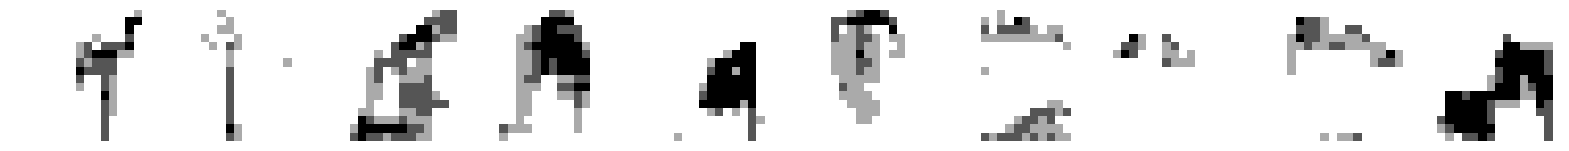

469/469 [==============================] - 21s 40ms/step - loss: 0.4920
Epoch 2/150
469/469 [==============================] - ETA: 0s - loss: 0.3996
Saved to 05_02_pixelcnn/output/generated_img_001.png


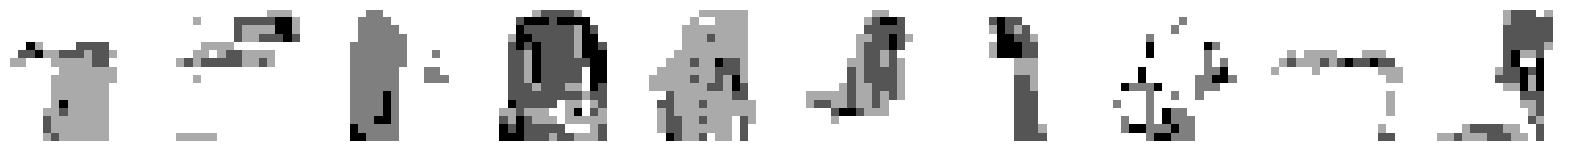

469/469 [==============================] - 18s 39ms/step - loss: 0.3996
Epoch 3/150
469/469 [==============================] - ETA: 0s - loss: 0.3879
Saved to 05_02_pixelcnn/output/generated_img_002.png


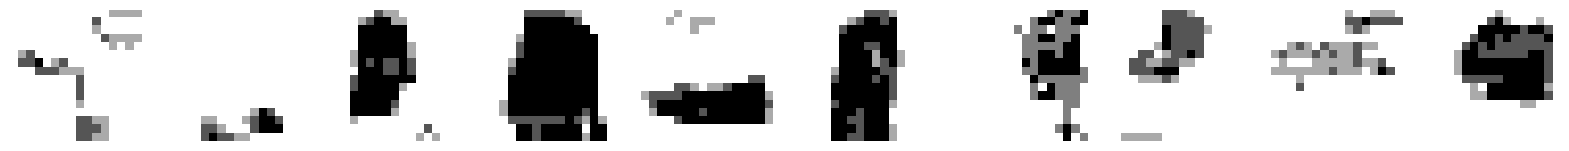

469/469 [==============================] - 19s 41ms/step - loss: 0.3879
Epoch 4/150
469/469 [==============================] - ETA: 0s - loss: 0.3818
Saved to 05_02_pixelcnn/output/generated_img_003.png


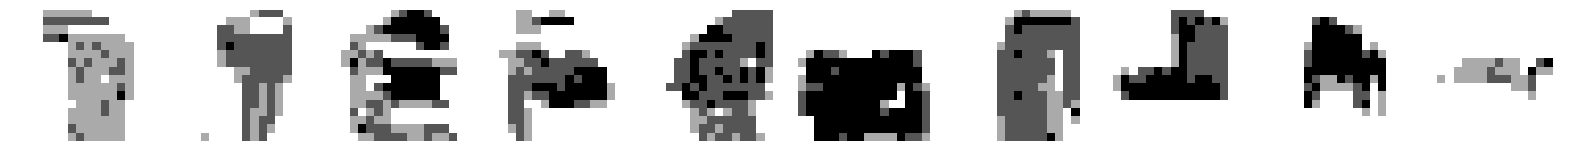

469/469 [==============================] - 19s 40ms/step - loss: 0.3818
Epoch 5/150
469/469 [==============================] - ETA: 0s - loss: 0.3774
Saved to 05_02_pixelcnn/output/generated_img_004.png


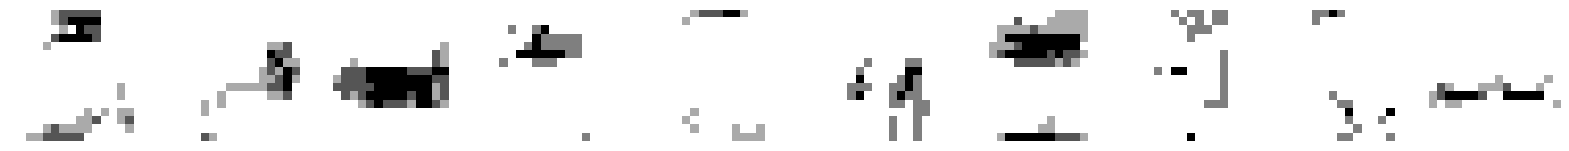

469/469 [==============================] - 19s 40ms/step - loss: 0.3774
Epoch 6/150
469/469 [==============================] - ETA: 0s - loss: 0.3744
Saved to 05_02_pixelcnn/output/generated_img_005.png


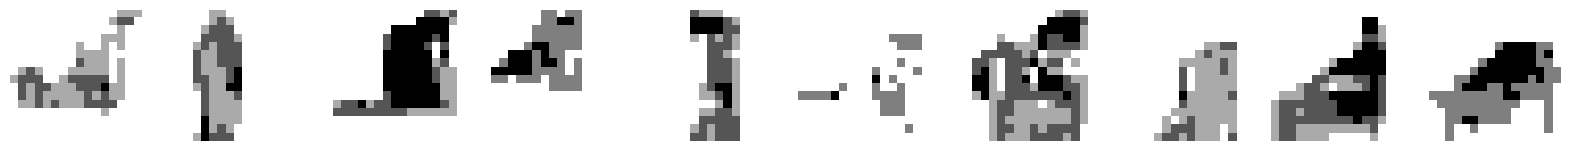

469/469 [==============================] - 18s 39ms/step - loss: 0.3744
Epoch 7/150
469/469 [==============================] - ETA: 0s - loss: 0.3718
Saved to 05_02_pixelcnn/output/generated_img_006.png


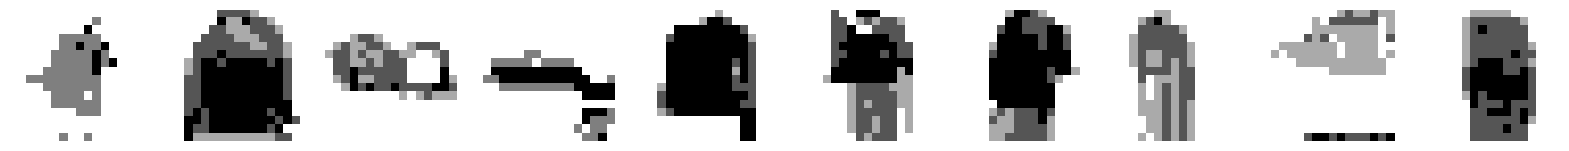

469/469 [==============================] - 19s 40ms/step - loss: 0.3718
Epoch 8/150
469/469 [==============================] - ETA: 0s - loss: 0.3691
Saved to 05_02_pixelcnn/output/generated_img_007.png


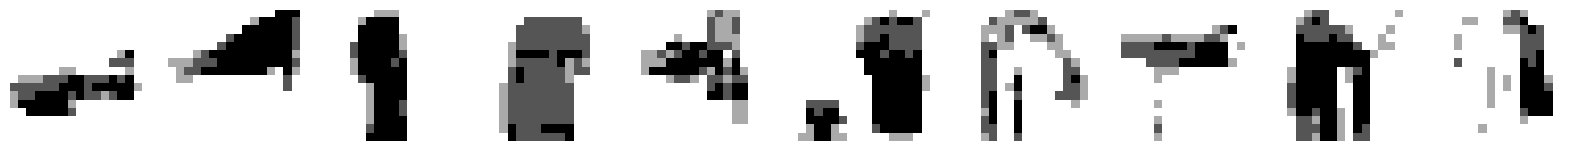

469/469 [==============================] - 19s 40ms/step - loss: 0.3691
Epoch 9/150
469/469 [==============================] - ETA: 0s - loss: 0.3675
Saved to 05_02_pixelcnn/output/generated_img_008.png


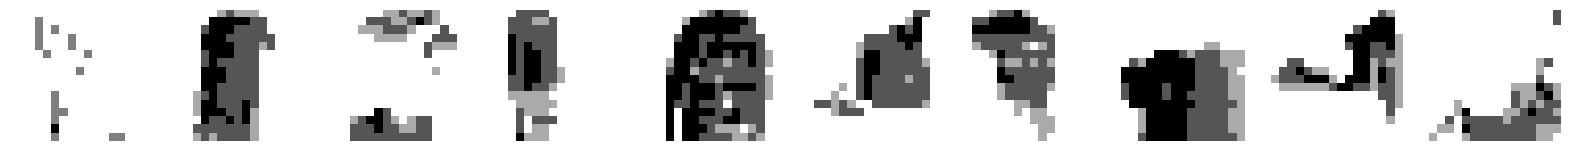

469/469 [==============================] - 19s 41ms/step - loss: 0.3675
Epoch 10/150
469/469 [==============================] - ETA: 0s - loss: 0.3651
Saved to 05_02_pixelcnn/output/generated_img_009.png


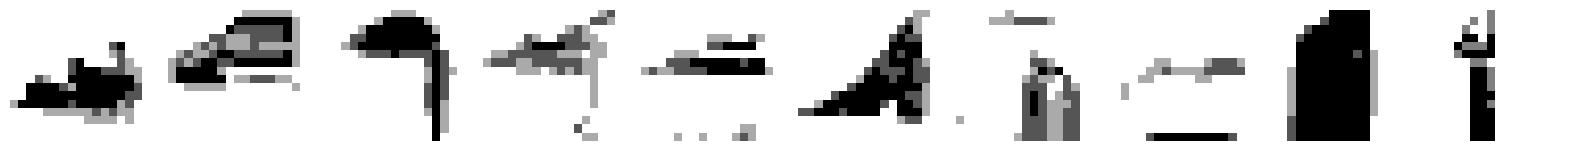

469/469 [==============================] - 19s 40ms/step - loss: 0.3651
Epoch 11/150
469/469 [==============================] - ETA: 0s - loss: 0.3632
Saved to 05_02_pixelcnn/output/generated_img_010.png


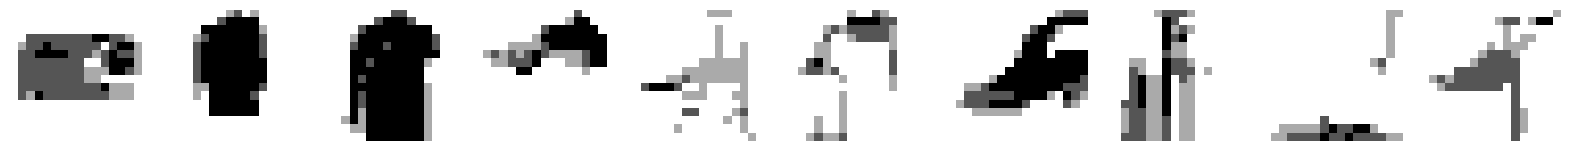

469/469 [==============================] - 19s 41ms/step - loss: 0.3632
Epoch 12/150
469/469 [==============================] - ETA: 0s - loss: 0.3615
Saved to 05_02_pixelcnn/output/generated_img_011.png


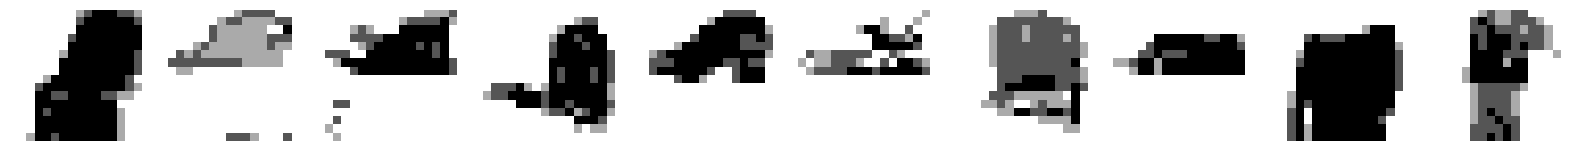

469/469 [==============================] - 19s 40ms/step - loss: 0.3615
Epoch 13/150
469/469 [==============================] - ETA: 0s - loss: 0.3590
Saved to 05_02_pixelcnn/output/generated_img_012.png


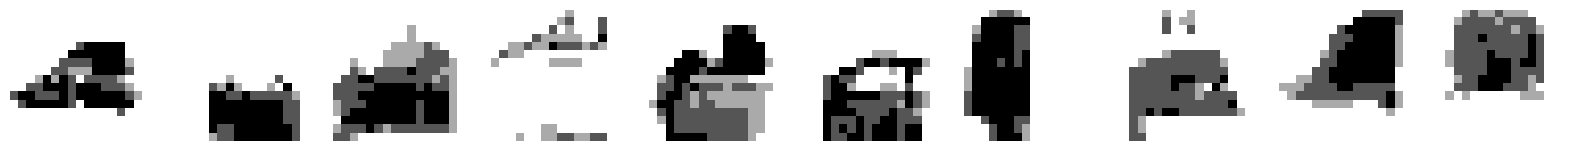

469/469 [==============================] - 19s 40ms/step - loss: 0.3590
Epoch 14/150
469/469 [==============================] - ETA: 0s - loss: 0.3577
Saved to 05_02_pixelcnn/output/generated_img_013.png


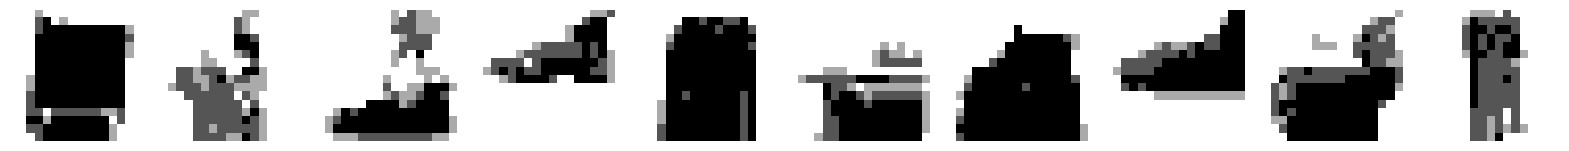

469/469 [==============================] - 18s 39ms/step - loss: 0.3577
Epoch 15/150
469/469 [==============================] - ETA: 0s - loss: 0.3560
Saved to 05_02_pixelcnn/output/generated_img_014.png


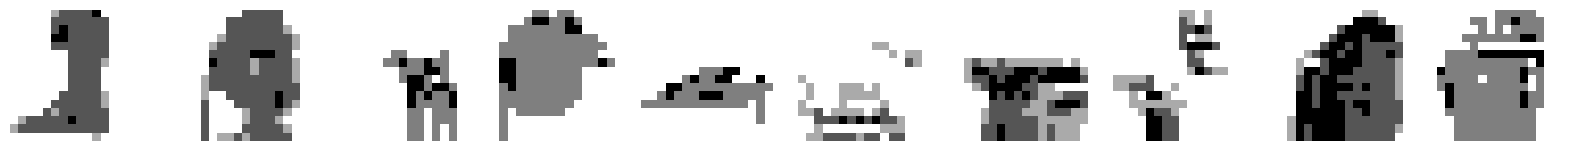

469/469 [==============================] - 19s 40ms/step - loss: 0.3560
Epoch 16/150
469/469 [==============================] - ETA: 0s - loss: 0.3545
Saved to 05_02_pixelcnn/output/generated_img_015.png


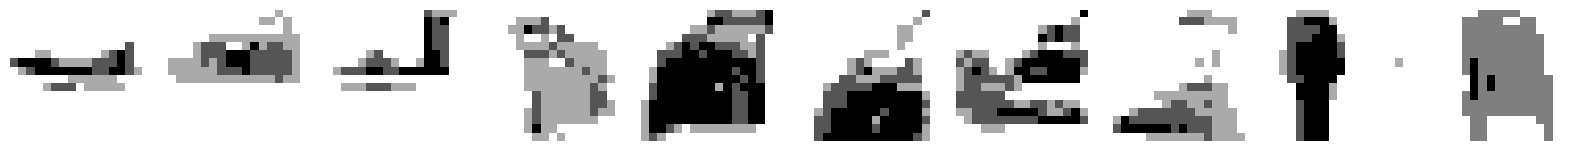

469/469 [==============================] - 18s 39ms/step - loss: 0.3545
Epoch 17/150
469/469 [==============================] - ETA: 0s - loss: 0.3536
Saved to 05_02_pixelcnn/output/generated_img_016.png


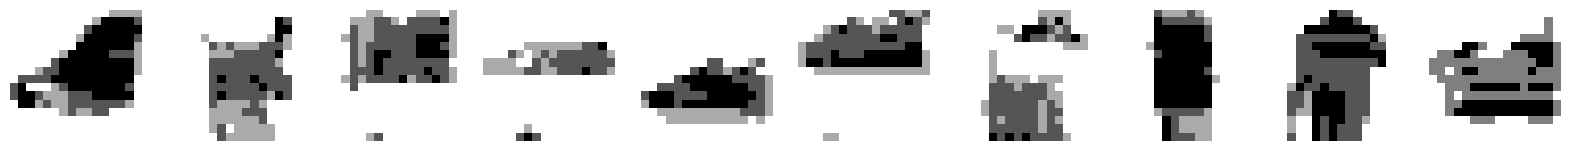

469/469 [==============================] - 19s 40ms/step - loss: 0.3536
Epoch 18/150
469/469 [==============================] - ETA: 0s - loss: 0.3523
Saved to 05_02_pixelcnn/output/generated_img_017.png


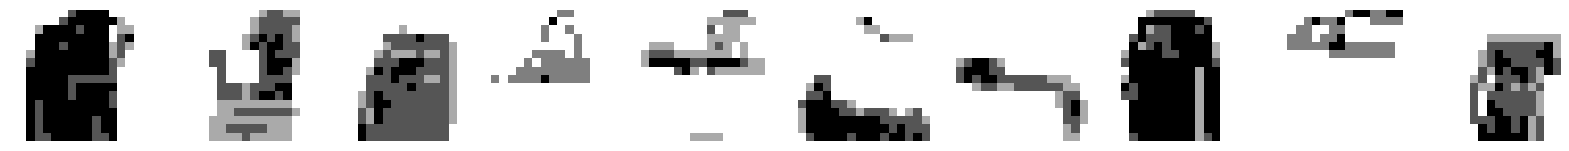

469/469 [==============================] - 18s 39ms/step - loss: 0.3523
Epoch 19/150
469/469 [==============================] - ETA: 0s - loss: 0.3511
Saved to 05_02_pixelcnn/output/generated_img_018.png


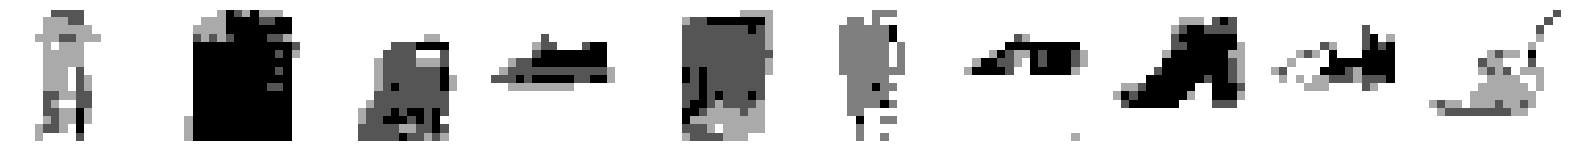

469/469 [==============================] - 19s 40ms/step - loss: 0.3511
Epoch 20/150
469/469 [==============================] - ETA: 0s - loss: 0.3502
Saved to 05_02_pixelcnn/output/generated_img_019.png


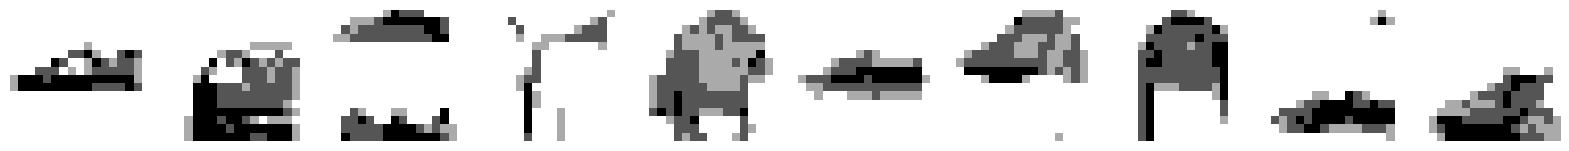

469/469 [==============================] - 19s 40ms/step - loss: 0.3502
Epoch 21/150
469/469 [==============================] - ETA: 0s - loss: 0.3492
Saved to 05_02_pixelcnn/output/generated_img_020.png


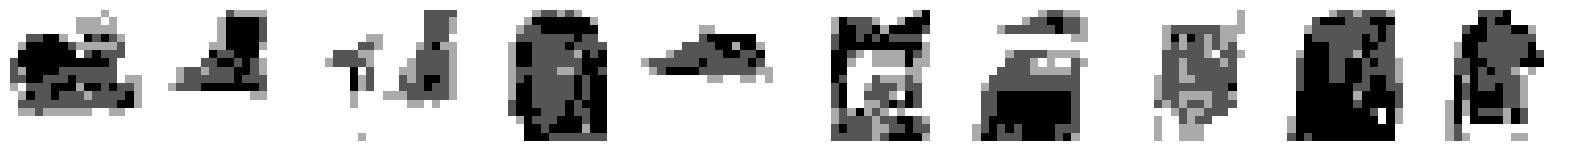

469/469 [==============================] - 19s 40ms/step - loss: 0.3492
Epoch 22/150
469/469 [==============================] - ETA: 0s - loss: 0.3487
Saved to 05_02_pixelcnn/output/generated_img_021.png


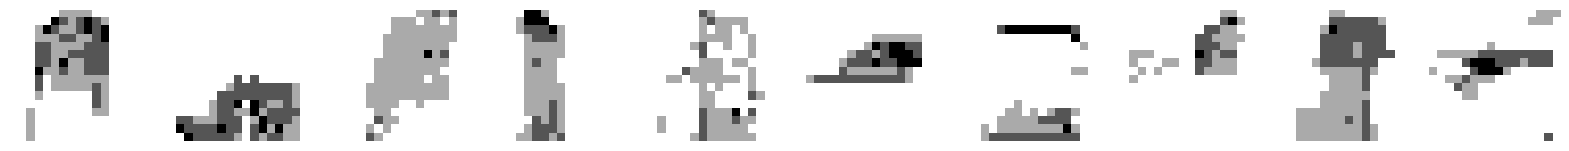

469/469 [==============================] - 19s 40ms/step - loss: 0.3487
Epoch 23/150
469/469 [==============================] - ETA: 0s - loss: 0.3477
Saved to 05_02_pixelcnn/output/generated_img_022.png


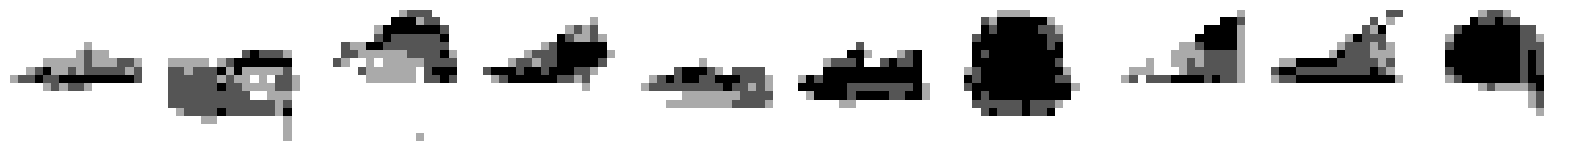

469/469 [==============================] - 19s 40ms/step - loss: 0.3477
Epoch 24/150
469/469 [==============================] - ETA: 0s - loss: 0.3472
Saved to 05_02_pixelcnn/output/generated_img_023.png


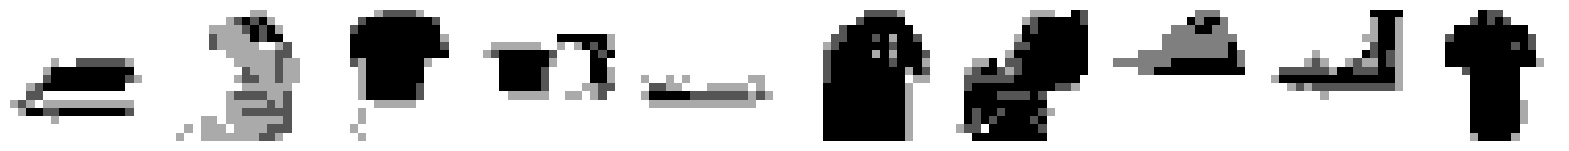

469/469 [==============================] - 18s 39ms/step - loss: 0.3472
Epoch 25/150
469/469 [==============================] - ETA: 0s - loss: 0.3465
Saved to 05_02_pixelcnn/output/generated_img_024.png


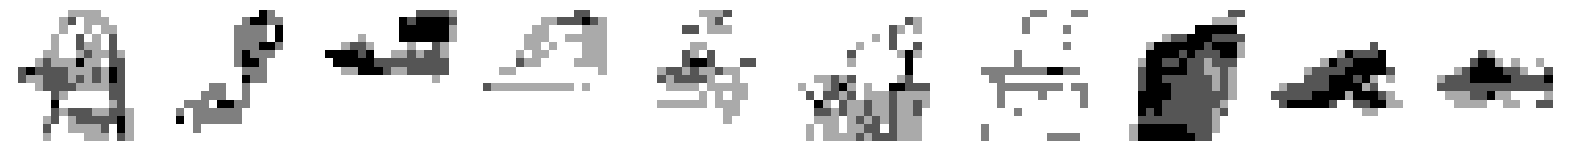

469/469 [==============================] - 19s 40ms/step - loss: 0.3465
Epoch 26/150
469/469 [==============================] - ETA: 0s - loss: 0.3458
Saved to 05_02_pixelcnn/output/generated_img_025.png


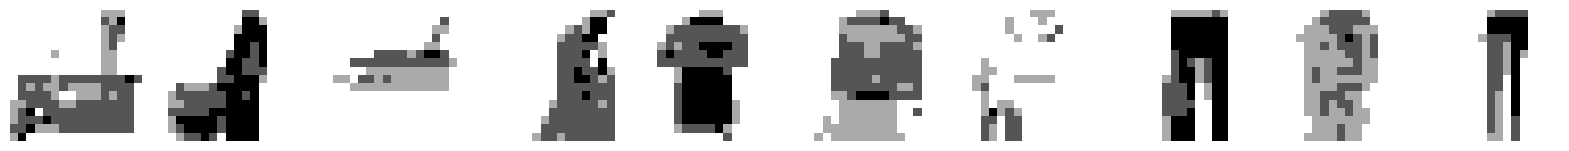

469/469 [==============================] - 18s 39ms/step - loss: 0.3458
Epoch 27/150
469/469 [==============================] - ETA: 0s - loss: 0.3450
Saved to 05_02_pixelcnn/output/generated_img_026.png


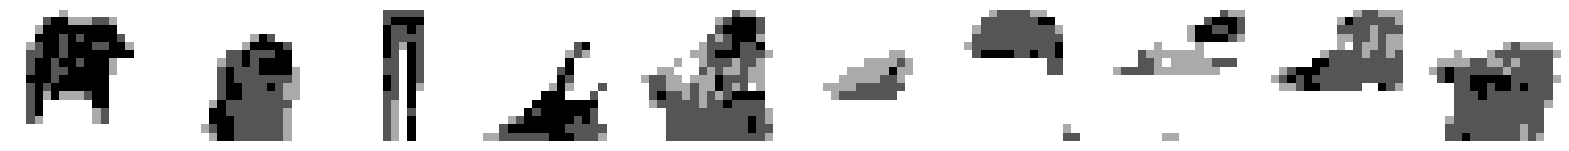

469/469 [==============================] - 19s 40ms/step - loss: 0.3450
Epoch 28/150
469/469 [==============================] - ETA: 0s - loss: 0.3443
Saved to 05_02_pixelcnn/output/generated_img_027.png


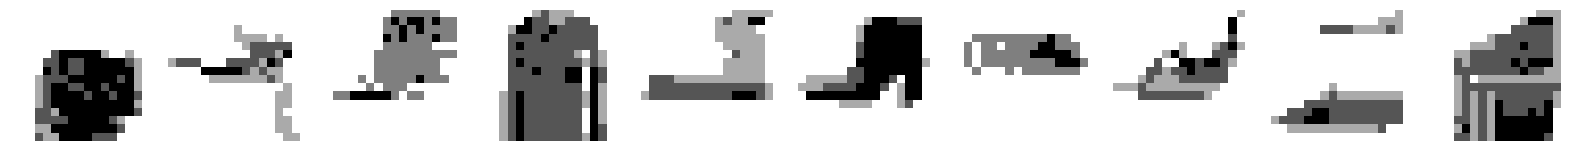

469/469 [==============================] - 18s 39ms/step - loss: 0.3443
Epoch 29/150
469/469 [==============================] - ETA: 0s - loss: 0.3442
Saved to 05_02_pixelcnn/output/generated_img_028.png


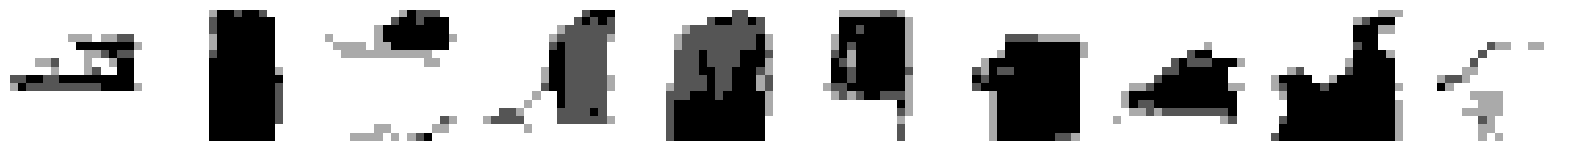

469/469 [==============================] - 19s 40ms/step - loss: 0.3442
Epoch 30/150
469/469 [==============================] - ETA: 0s - loss: 0.3437
Saved to 05_02_pixelcnn/output/generated_img_029.png


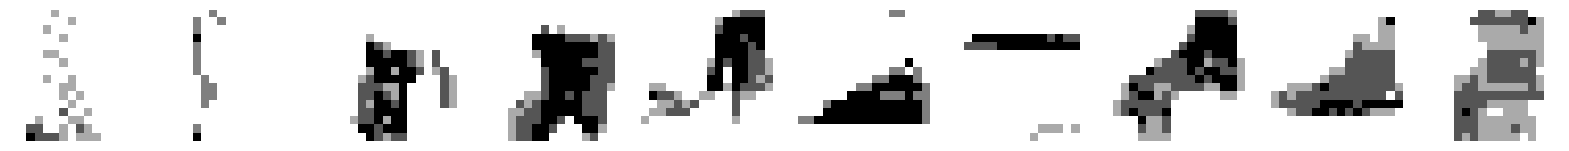

469/469 [==============================] - 19s 40ms/step - loss: 0.3437
Epoch 31/150
468/469 [============================>.] - ETA: 0s - loss: 0.3428
Saved to 05_02_pixelcnn/output/generated_img_030.png


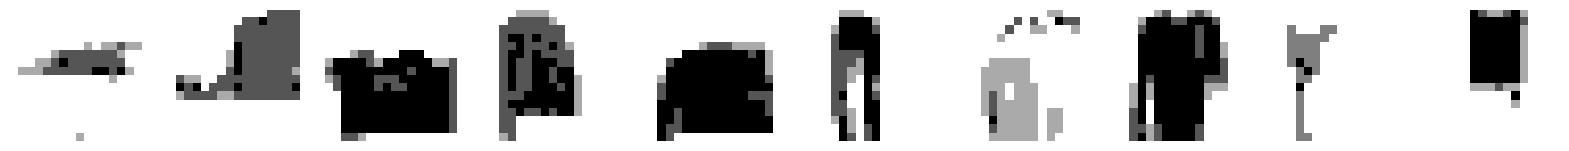

469/469 [==============================] - 19s 40ms/step - loss: 0.3428
Epoch 32/150
469/469 [==============================] - ETA: 0s - loss: 0.3426
Saved to 05_02_pixelcnn/output/generated_img_031.png


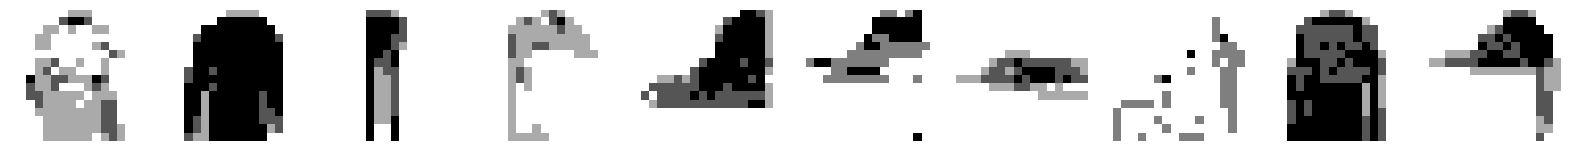

469/469 [==============================] - 19s 40ms/step - loss: 0.3426
Epoch 33/150
469/469 [==============================] - ETA: 0s - loss: 0.3419
Saved to 05_02_pixelcnn/output/generated_img_032.png


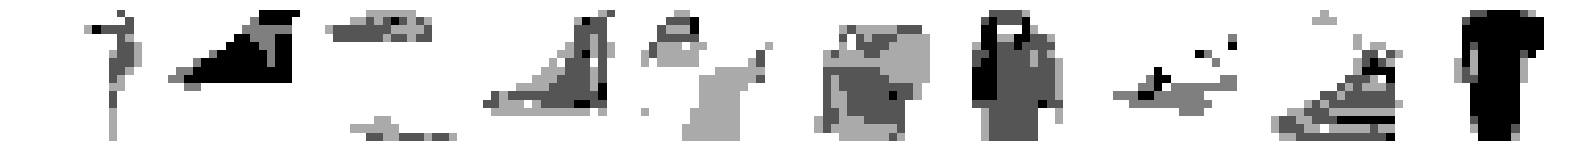

469/469 [==============================] - 18s 39ms/step - loss: 0.3419
Epoch 34/150
469/469 [==============================] - ETA: 0s - loss: 0.3415
Saved to 05_02_pixelcnn/output/generated_img_033.png


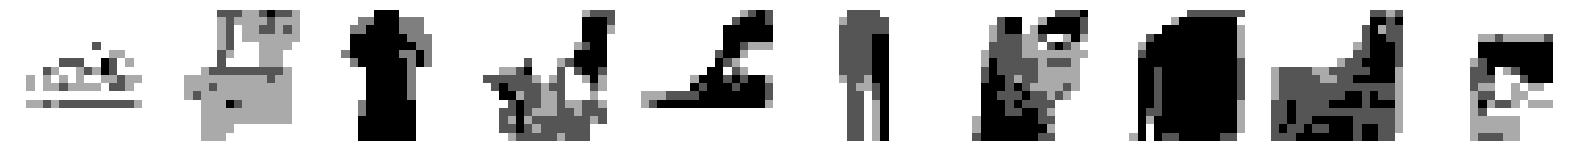

469/469 [==============================] - 19s 40ms/step - loss: 0.3415
Epoch 35/150
468/469 [============================>.] - ETA: 0s - loss: 0.3411
Saved to 05_02_pixelcnn/output/generated_img_034.png


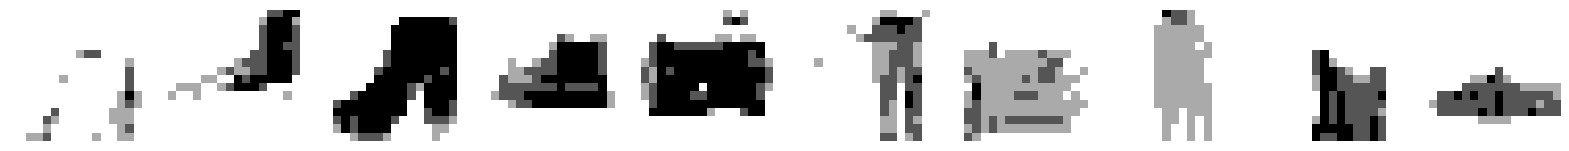

469/469 [==============================] - 18s 39ms/step - loss: 0.3411
Epoch 36/150
469/469 [==============================] - ETA: 0s - loss: 0.3407
Saved to 05_02_pixelcnn/output/generated_img_035.png


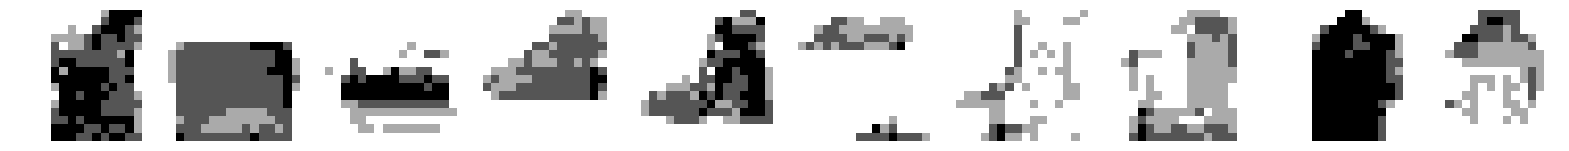

469/469 [==============================] - 19s 40ms/step - loss: 0.3407
Epoch 37/150
468/469 [============================>.] - ETA: 0s - loss: 0.3402
Saved to 05_02_pixelcnn/output/generated_img_036.png


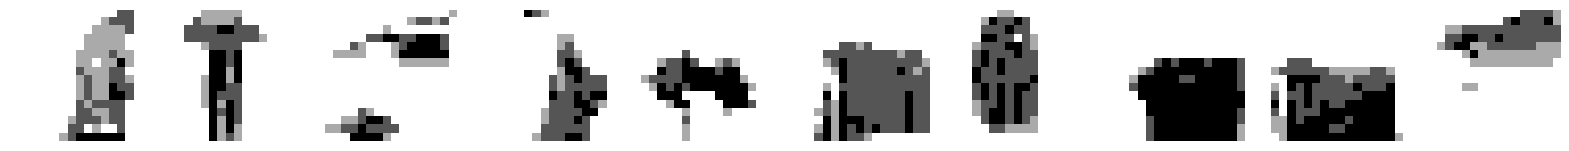

469/469 [==============================] - 19s 40ms/step - loss: 0.3402
Epoch 38/150
468/469 [============================>.] - ETA: 0s - loss: 0.3401
Saved to 05_02_pixelcnn/output/generated_img_037.png


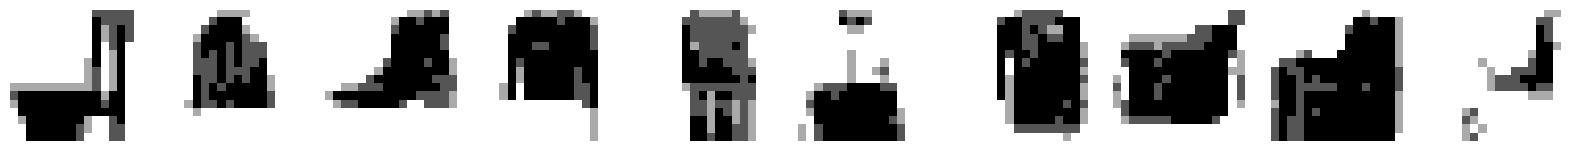

469/469 [==============================] - 19s 41ms/step - loss: 0.3401
Epoch 39/150
469/469 [==============================] - ETA: 0s - loss: 0.3394
Saved to 05_02_pixelcnn/output/generated_img_038.png


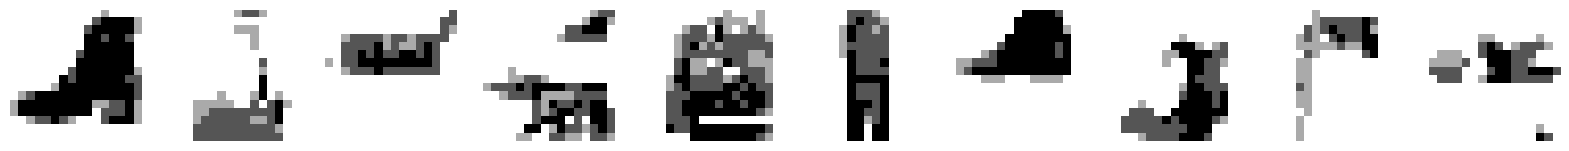

469/469 [==============================] - 19s 40ms/step - loss: 0.3394
Epoch 40/150
468/469 [============================>.] - ETA: 0s - loss: 0.3390
Saved to 05_02_pixelcnn/output/generated_img_039.png


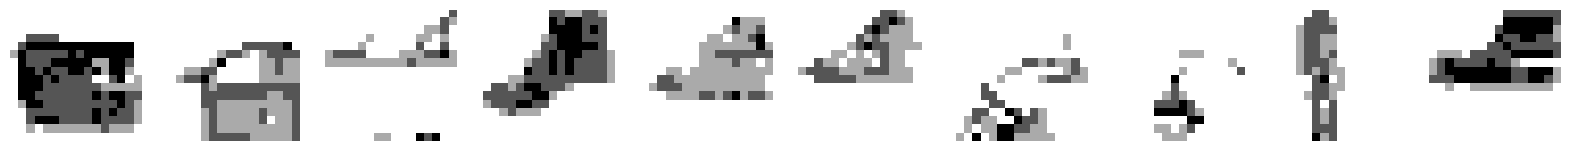

469/469 [==============================] - 19s 41ms/step - loss: 0.3391
Epoch 41/150
469/469 [==============================] - ETA: 0s - loss: 0.3387
Saved to 05_02_pixelcnn/output/generated_img_040.png


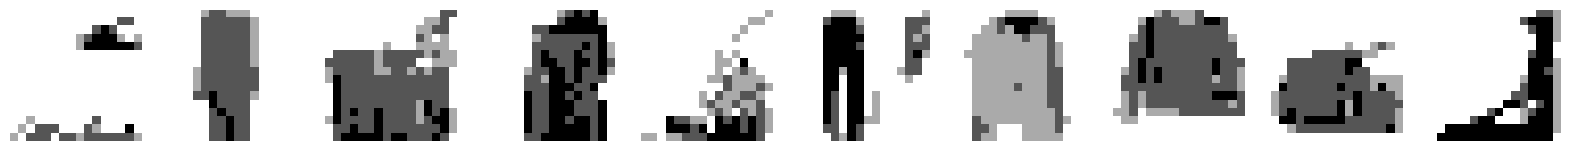

469/469 [==============================] - 19s 40ms/step - loss: 0.3387
Epoch 42/150
469/469 [==============================] - ETA: 0s - loss: 0.3385
Saved to 05_02_pixelcnn/output/generated_img_041.png


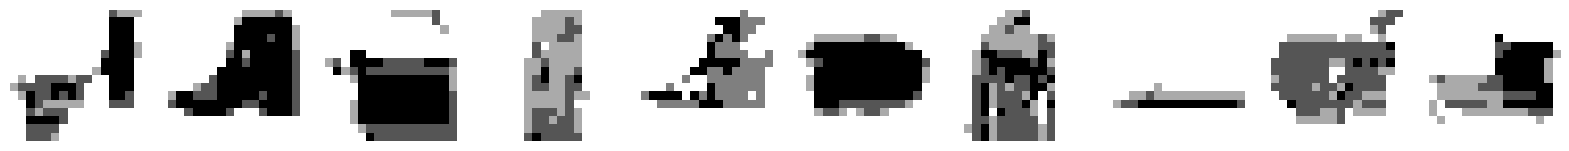

469/469 [==============================] - 19s 41ms/step - loss: 0.3385
Epoch 43/150
469/469 [==============================] - ETA: 0s - loss: 0.3382
Saved to 05_02_pixelcnn/output/generated_img_042.png


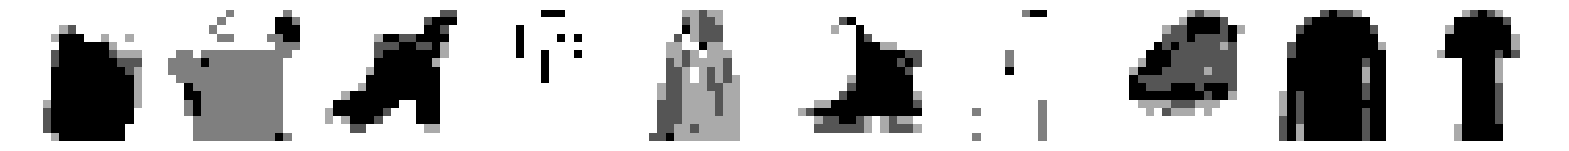

469/469 [==============================] - 19s 40ms/step - loss: 0.3382
Epoch 44/150
469/469 [==============================] - ETA: 0s - loss: 0.3378
Saved to 05_02_pixelcnn/output/generated_img_043.png


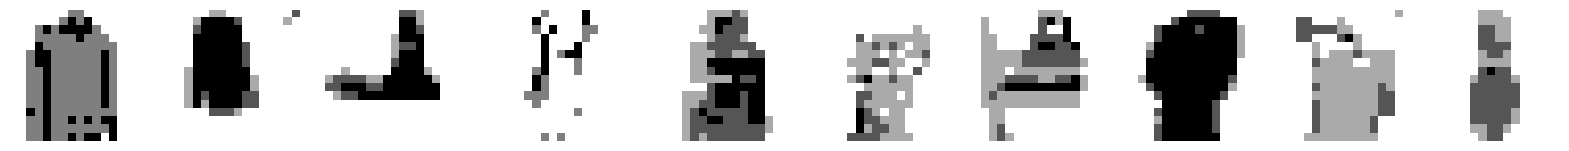

469/469 [==============================] - 19s 40ms/step - loss: 0.3378
Epoch 45/150
469/469 [==============================] - ETA: 0s - loss: 0.3376
Saved to 05_02_pixelcnn/output/generated_img_044.png


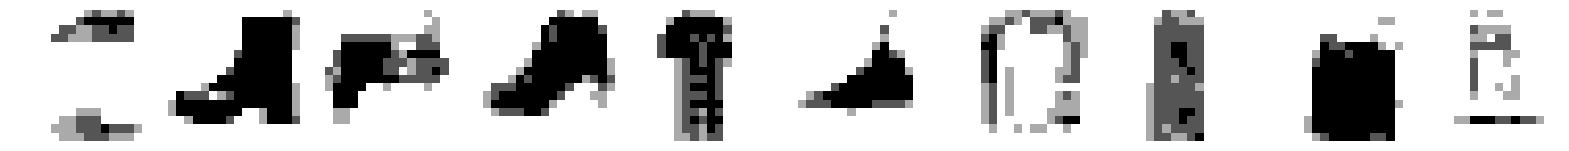

469/469 [==============================] - 19s 40ms/step - loss: 0.3376
Epoch 46/150
469/469 [==============================] - ETA: 0s - loss: 0.3370
Saved to 05_02_pixelcnn/output/generated_img_045.png


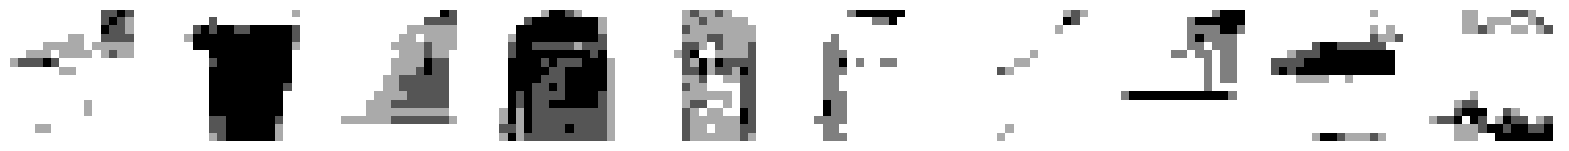

469/469 [==============================] - 19s 40ms/step - loss: 0.3370
Epoch 47/150
468/469 [============================>.] - ETA: 0s - loss: 0.3369
Saved to 05_02_pixelcnn/output/generated_img_046.png


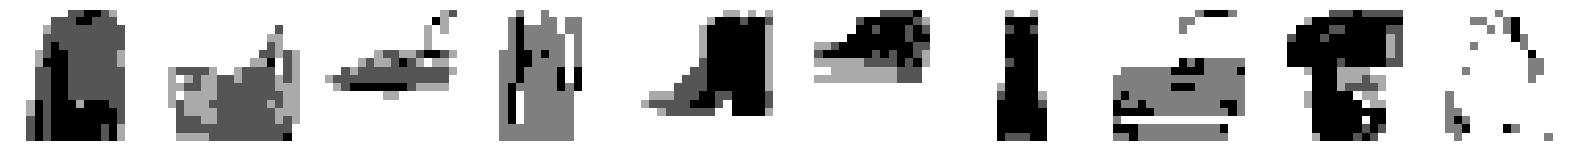

469/469 [==============================] - 18s 39ms/step - loss: 0.3369
Epoch 48/150
469/469 [==============================] - ETA: 0s - loss: 0.3367
Saved to 05_02_pixelcnn/output/generated_img_047.png


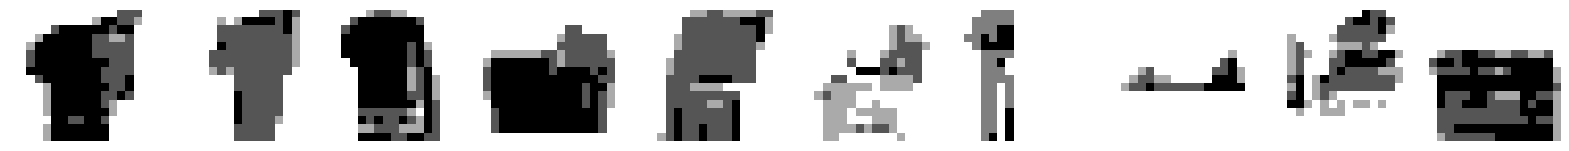

469/469 [==============================] - 19s 40ms/step - loss: 0.3367
Epoch 49/150
469/469 [==============================] - ETA: 0s - loss: 0.3364
Saved to 05_02_pixelcnn/output/generated_img_048.png


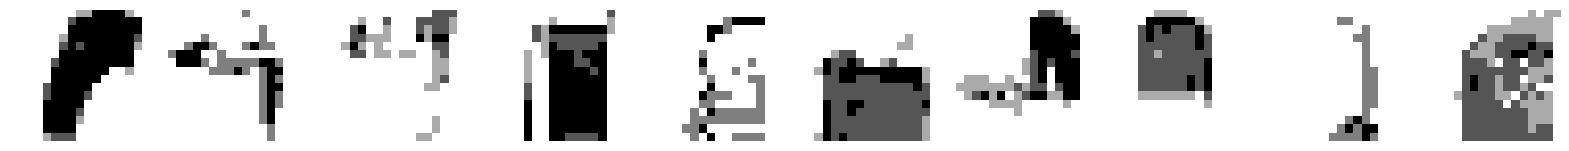

469/469 [==============================] - 19s 40ms/step - loss: 0.3364
Epoch 50/150
469/469 [==============================] - ETA: 0s - loss: 0.3362
Saved to 05_02_pixelcnn/output/generated_img_049.png


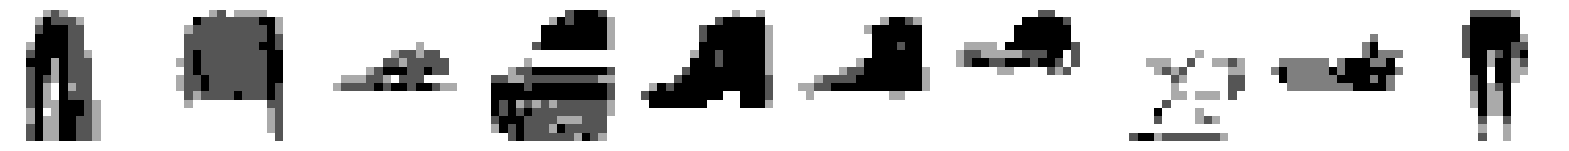

469/469 [==============================] - 19s 41ms/step - loss: 0.3362
Epoch 51/150
469/469 [==============================] - ETA: 0s - loss: 0.3358
Saved to 05_02_pixelcnn/output/generated_img_050.png


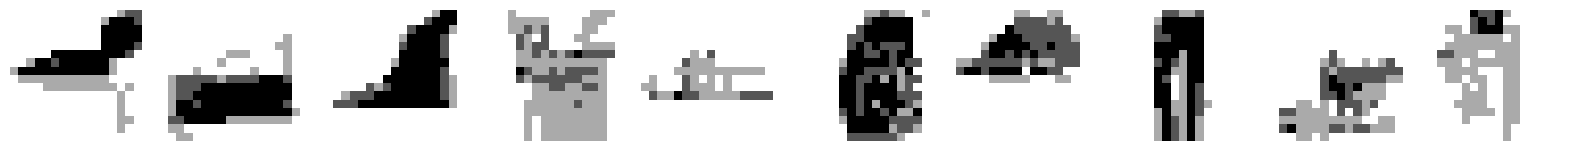

469/469 [==============================] - 19s 40ms/step - loss: 0.3358
Epoch 52/150
468/469 [============================>.] - ETA: 0s - loss: 0.3357
Saved to 05_02_pixelcnn/output/generated_img_051.png


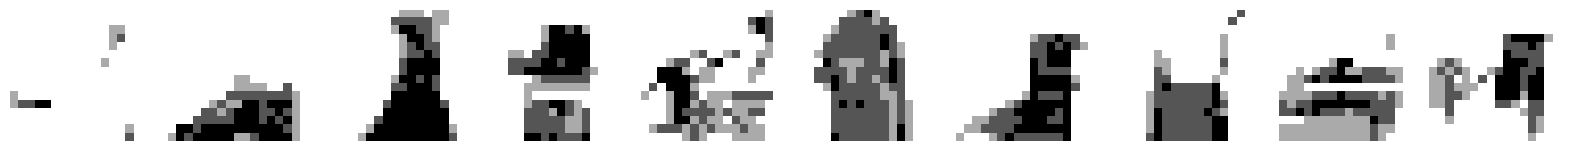

469/469 [==============================] - 19s 40ms/step - loss: 0.3357
Epoch 53/150
469/469 [==============================] - ETA: 0s - loss: 0.3354
Saved to 05_02_pixelcnn/output/generated_img_052.png


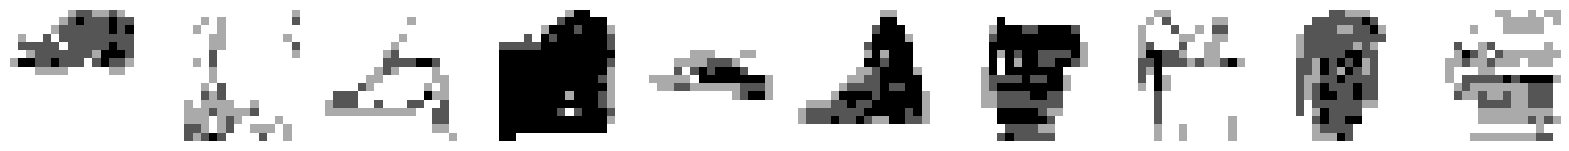

469/469 [==============================] - 19s 40ms/step - loss: 0.3354
Epoch 54/150
469/469 [==============================] - ETA: 0s - loss: 0.3351
Saved to 05_02_pixelcnn/output/generated_img_053.png


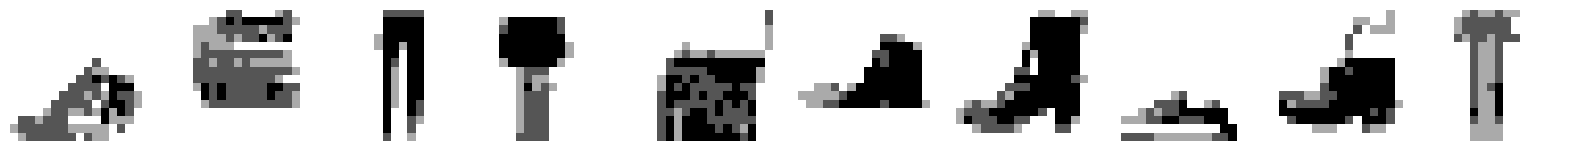

469/469 [==============================] - 19s 40ms/step - loss: 0.3351
Epoch 55/150
469/469 [==============================] - ETA: 0s - loss: 0.3349
Saved to 05_02_pixelcnn/output/generated_img_054.png


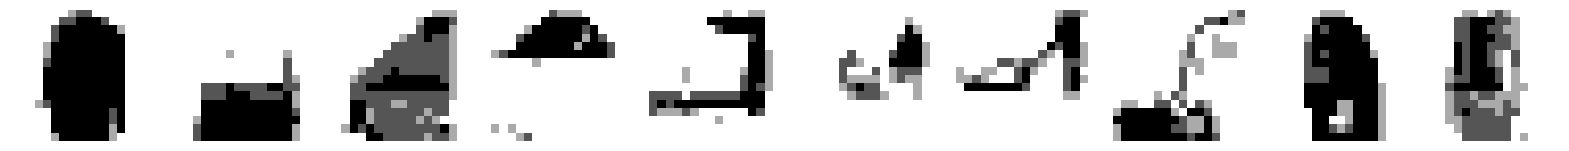

469/469 [==============================] - 19s 40ms/step - loss: 0.3349
Epoch 56/150
469/469 [==============================] - ETA: 0s - loss: 0.3347
Saved to 05_02_pixelcnn/output/generated_img_055.png


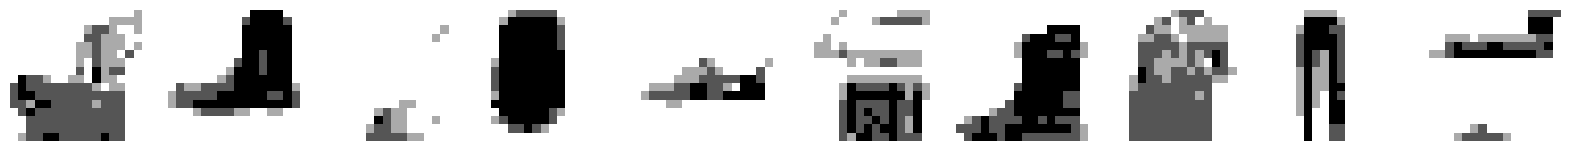

469/469 [==============================] - 19s 40ms/step - loss: 0.3347
Epoch 57/150
469/469 [==============================] - ETA: 0s - loss: 0.3345
Saved to 05_02_pixelcnn/output/generated_img_056.png


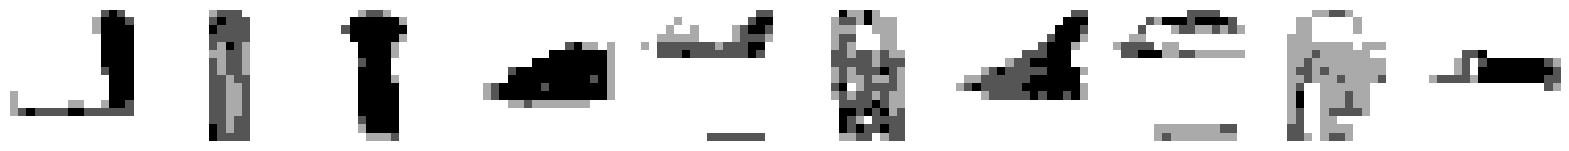

469/469 [==============================] - 19s 40ms/step - loss: 0.3345
Epoch 58/150
469/469 [==============================] - ETA: 0s - loss: 0.3342
Saved to 05_02_pixelcnn/output/generated_img_057.png


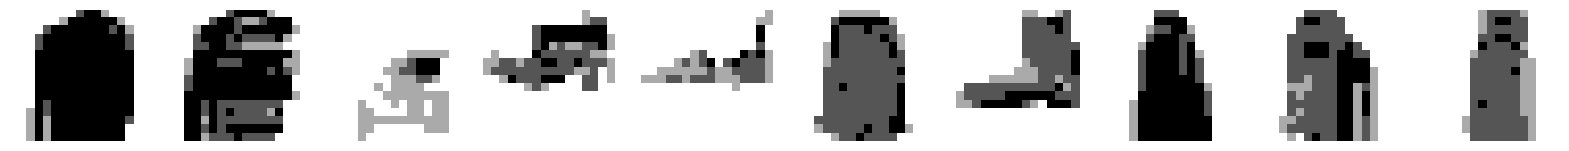

469/469 [==============================] - 19s 40ms/step - loss: 0.3342
Epoch 59/150
469/469 [==============================] - ETA: 0s - loss: 0.3340
Saved to 05_02_pixelcnn/output/generated_img_058.png


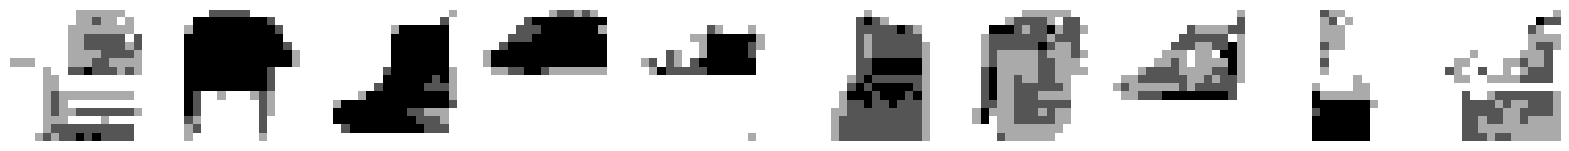

469/469 [==============================] - 19s 40ms/step - loss: 0.3340
Epoch 60/150
468/469 [============================>.] - ETA: 0s - loss: 0.3337
Saved to 05_02_pixelcnn/output/generated_img_059.png


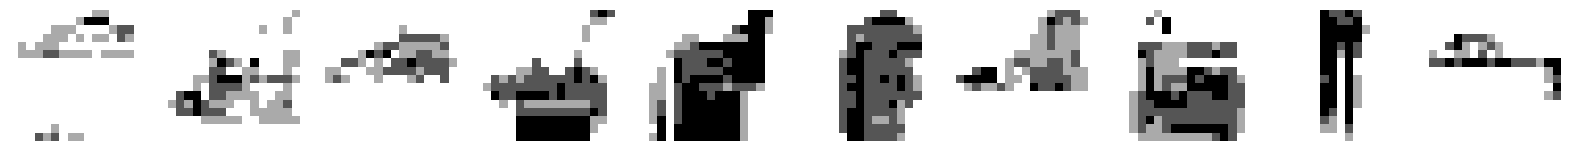

469/469 [==============================] - 19s 40ms/step - loss: 0.3337
Epoch 61/150
469/469 [==============================] - ETA: 0s - loss: 0.3336
Saved to 05_02_pixelcnn/output/generated_img_060.png


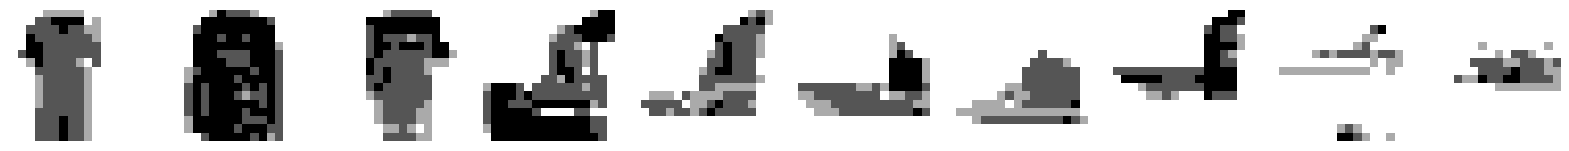

469/469 [==============================] - 19s 40ms/step - loss: 0.3336
Epoch 62/150
469/469 [==============================] - ETA: 0s - loss: 0.3334
Saved to 05_02_pixelcnn/output/generated_img_061.png


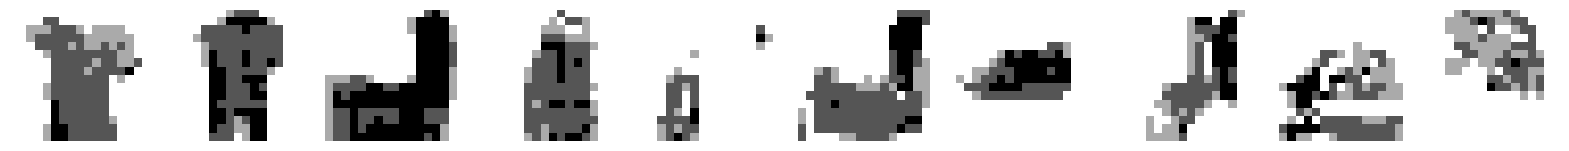

469/469 [==============================] - 19s 40ms/step - loss: 0.3334
Epoch 63/150
469/469 [==============================] - ETA: 0s - loss: 0.3332
Saved to 05_02_pixelcnn/output/generated_img_062.png


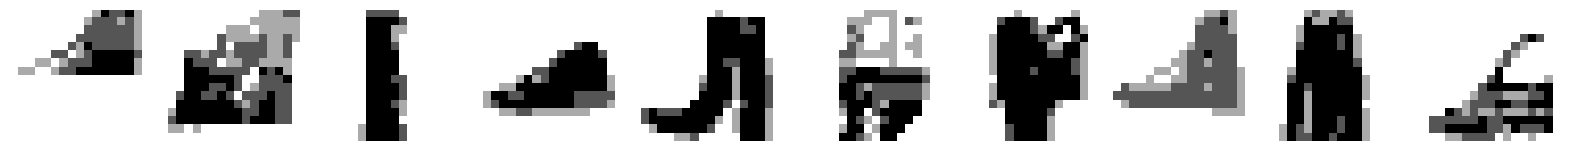

469/469 [==============================] - 19s 41ms/step - loss: 0.3332
Epoch 64/150
469/469 [==============================] - ETA: 0s - loss: 0.3330
Saved to 05_02_pixelcnn/output/generated_img_063.png


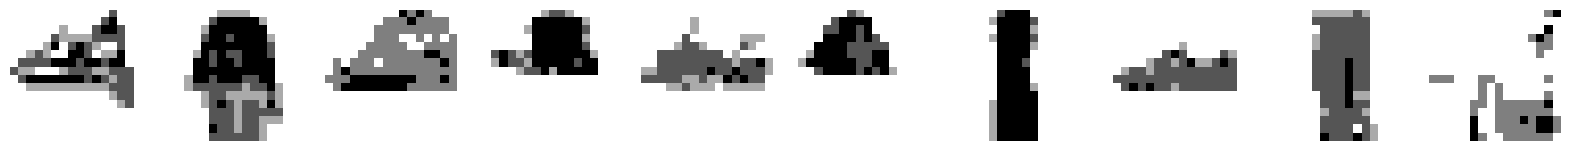

469/469 [==============================] - 18s 39ms/step - loss: 0.3330
Epoch 65/150
469/469 [==============================] - ETA: 0s - loss: 0.3328
Saved to 05_02_pixelcnn/output/generated_img_064.png


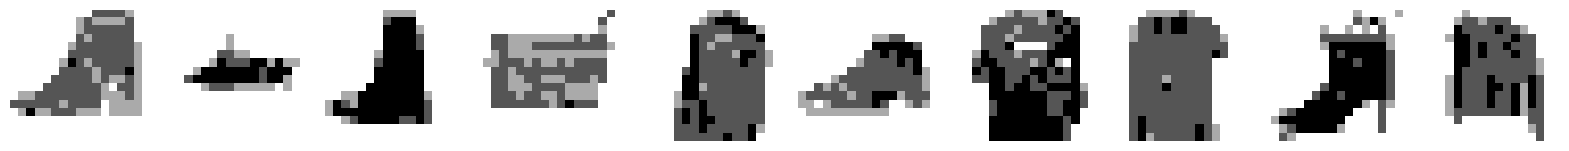

469/469 [==============================] - 19s 40ms/step - loss: 0.3328
Epoch 66/150
469/469 [==============================] - ETA: 0s - loss: 0.3327
Saved to 05_02_pixelcnn/output/generated_img_065.png


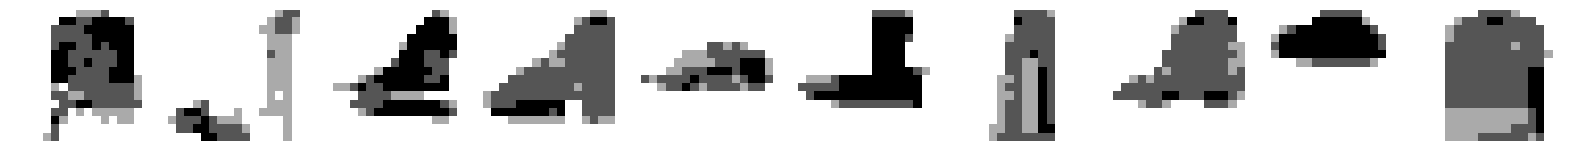

469/469 [==============================] - 19s 40ms/step - loss: 0.3327
Epoch 67/150
469/469 [==============================] - ETA: 0s - loss: 0.3324
Saved to 05_02_pixelcnn/output/generated_img_066.png


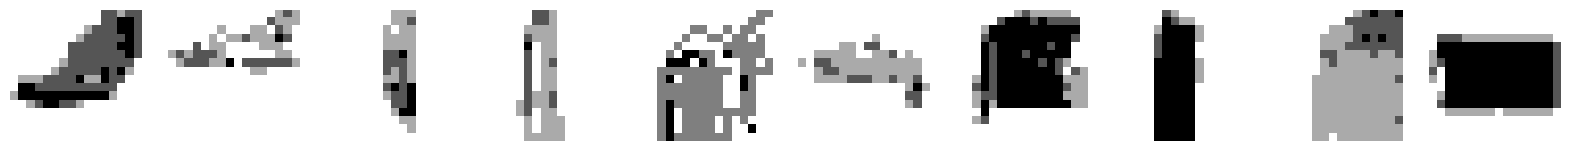

469/469 [==============================] - 19s 41ms/step - loss: 0.3324
Epoch 68/150
469/469 [==============================] - ETA: 0s - loss: 0.3322
Saved to 05_02_pixelcnn/output/generated_img_067.png


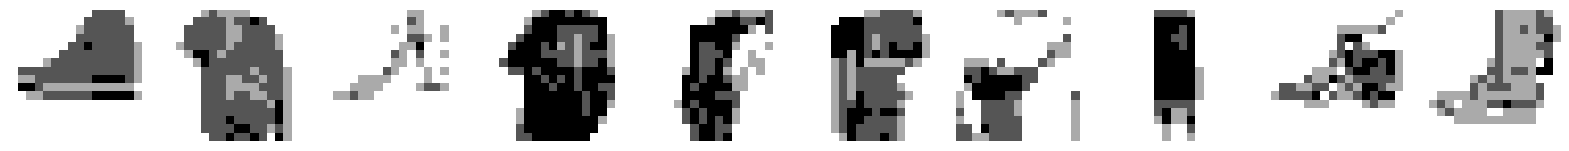

469/469 [==============================] - 19s 40ms/step - loss: 0.3322
Epoch 69/150
468/469 [============================>.] - ETA: 0s - loss: 0.3321
Saved to 05_02_pixelcnn/output/generated_img_068.png


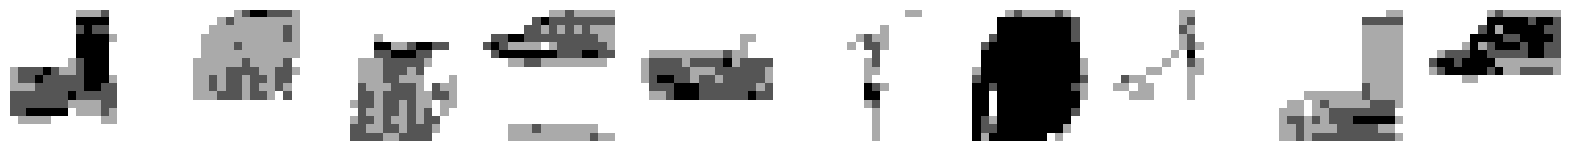

469/469 [==============================] - 19s 41ms/step - loss: 0.3321
Epoch 70/150
469/469 [==============================] - ETA: 0s - loss: 0.3321
Saved to 05_02_pixelcnn/output/generated_img_069.png


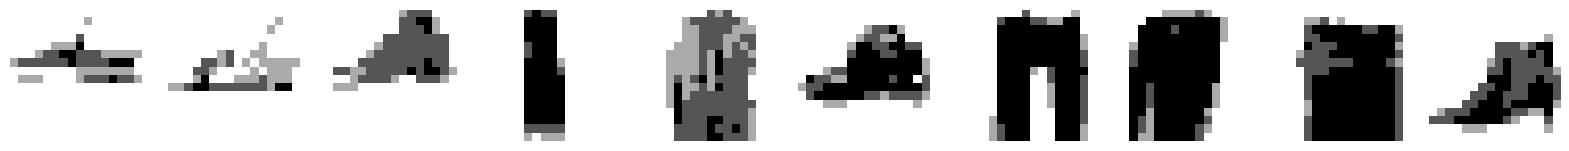

469/469 [==============================] - 19s 40ms/step - loss: 0.3321
Epoch 71/150
467/469 [============================>.] - ETA: 0s - loss: 0.3317
Saved to 05_02_pixelcnn/output/generated_img_070.png


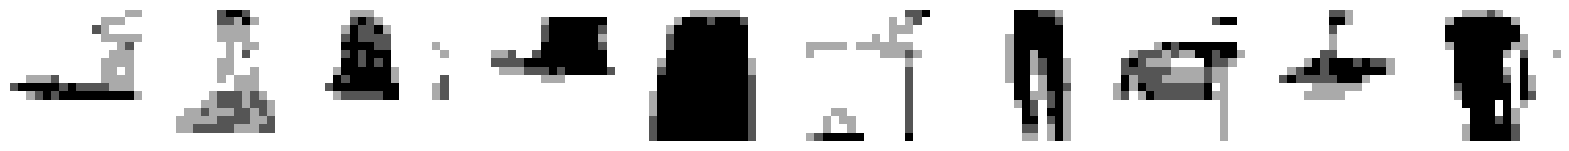

469/469 [==============================] - 19s 41ms/step - loss: 0.3317
Epoch 72/150
469/469 [==============================] - ETA: 0s - loss: 0.3315
Saved to 05_02_pixelcnn/output/generated_img_071.png


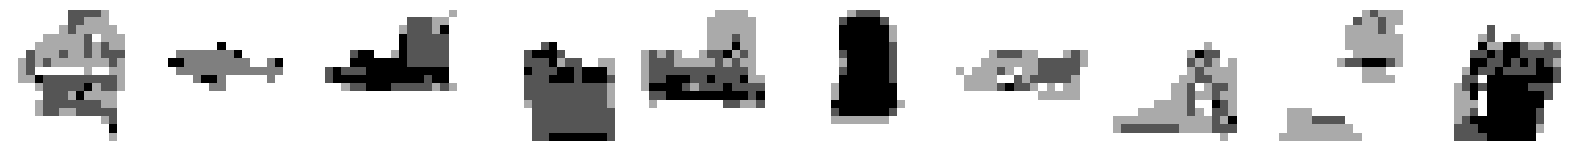

469/469 [==============================] - 19s 40ms/step - loss: 0.3315
Epoch 73/150
469/469 [==============================] - ETA: 0s - loss: 0.3315
Saved to 05_02_pixelcnn/output/generated_img_072.png


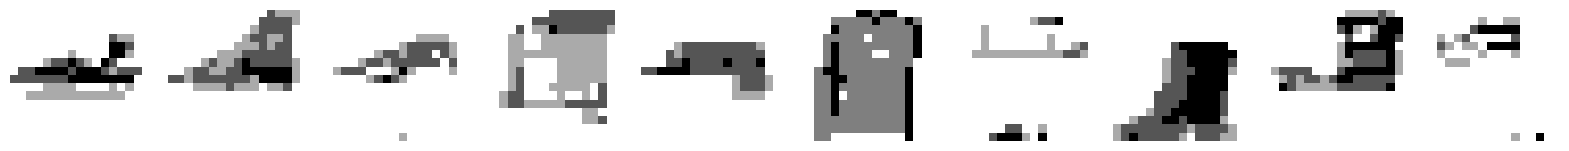

469/469 [==============================] - 19s 41ms/step - loss: 0.3315
Epoch 74/150
469/469 [==============================] - ETA: 0s - loss: 0.3312
Saved to 05_02_pixelcnn/output/generated_img_073.png


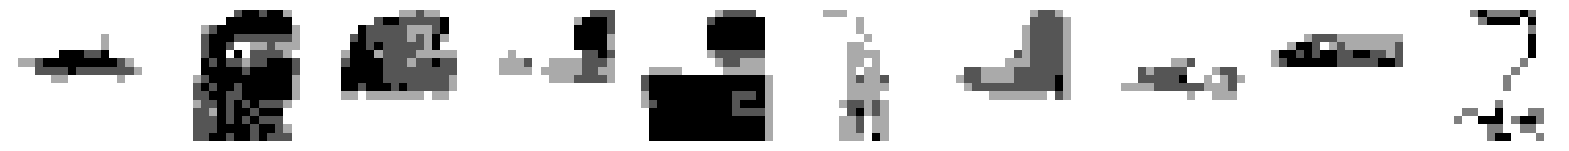

469/469 [==============================] - 19s 40ms/step - loss: 0.3312
Epoch 75/150
469/469 [==============================] - ETA: 0s - loss: 0.3312
Saved to 05_02_pixelcnn/output/generated_img_074.png


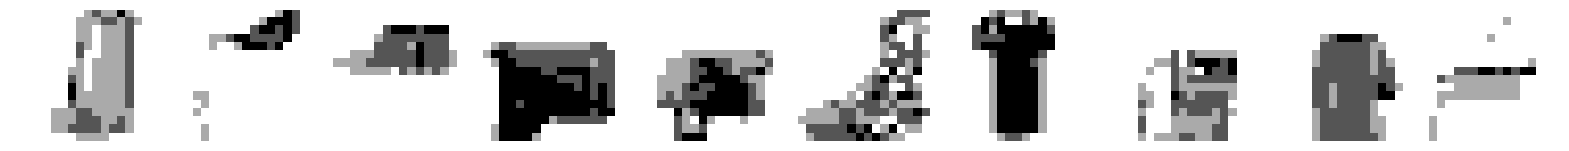

469/469 [==============================] - 19s 40ms/step - loss: 0.3312
Epoch 76/150
469/469 [==============================] - ETA: 0s - loss: 0.3307
Saved to 05_02_pixelcnn/output/generated_img_075.png


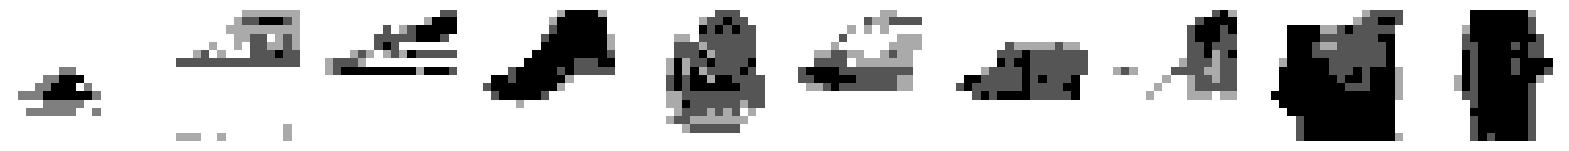

469/469 [==============================] - 19s 40ms/step - loss: 0.3307
Epoch 77/150
469/469 [==============================] - ETA: 0s - loss: 0.3309
Saved to 05_02_pixelcnn/output/generated_img_076.png


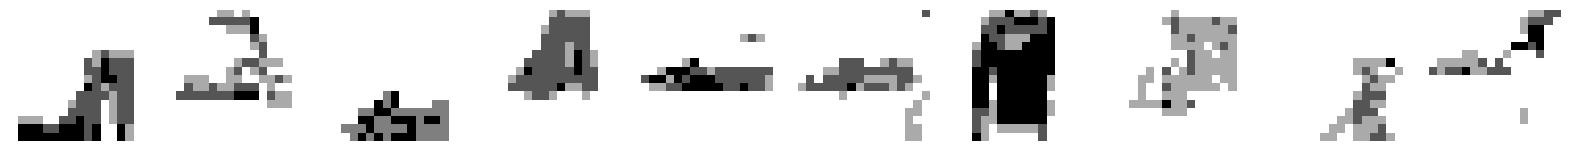

469/469 [==============================] - 19s 41ms/step - loss: 0.3309
Epoch 78/150
469/469 [==============================] - ETA: 0s - loss: 0.3307
Saved to 05_02_pixelcnn/output/generated_img_077.png


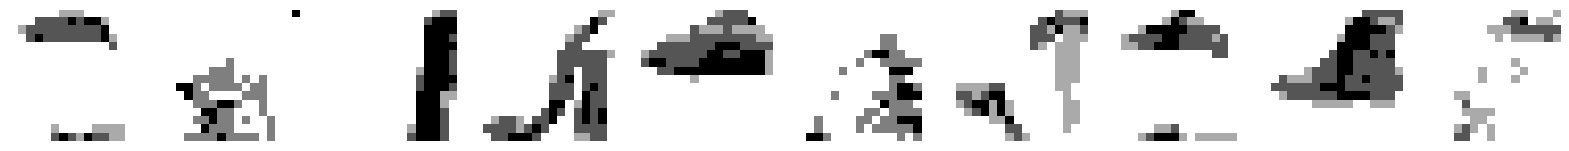

469/469 [==============================] - 19s 41ms/step - loss: 0.3307
Epoch 79/150
469/469 [==============================] - ETA: 0s - loss: 0.3305
Saved to 05_02_pixelcnn/output/generated_img_078.png


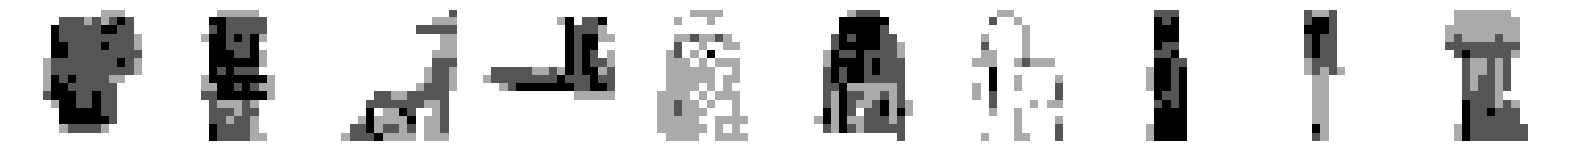

469/469 [==============================] - 19s 41ms/step - loss: 0.3305
Epoch 80/150
469/469 [==============================] - ETA: 0s - loss: 0.3304
Saved to 05_02_pixelcnn/output/generated_img_079.png


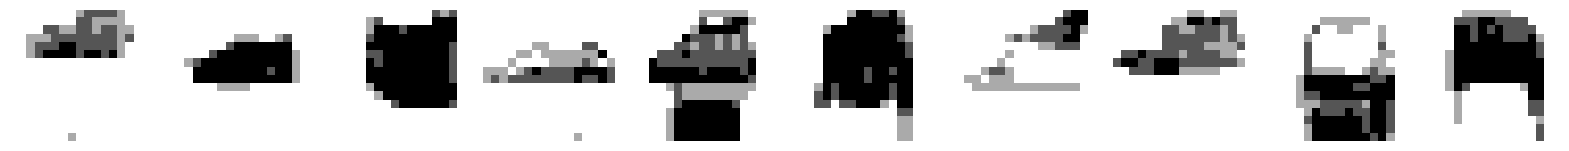

469/469 [==============================] - 19s 40ms/step - loss: 0.3304
Epoch 81/150
469/469 [==============================] - ETA: 0s - loss: 0.3302
Saved to 05_02_pixelcnn/output/generated_img_080.png


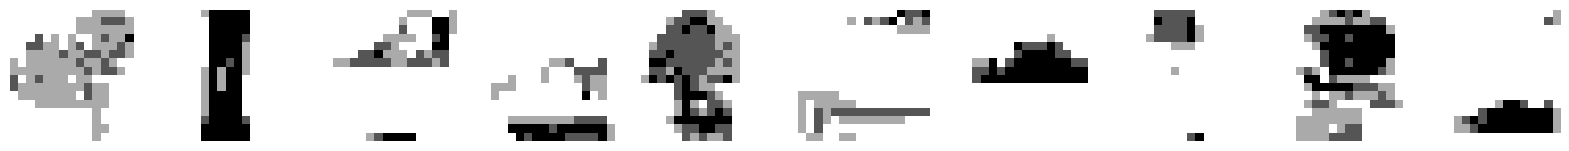

469/469 [==============================] - 19s 41ms/step - loss: 0.3302
Epoch 82/150
469/469 [==============================] - ETA: 0s - loss: 0.3300
Saved to 05_02_pixelcnn/output/generated_img_081.png


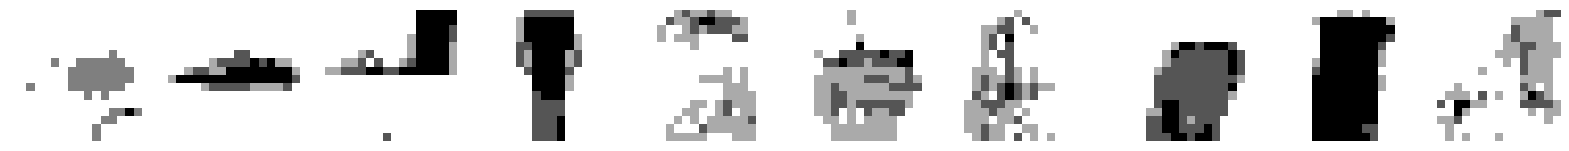

469/469 [==============================] - 19s 40ms/step - loss: 0.3300
Epoch 83/150
469/469 [==============================] - ETA: 0s - loss: 0.3299
Saved to 05_02_pixelcnn/output/generated_img_082.png


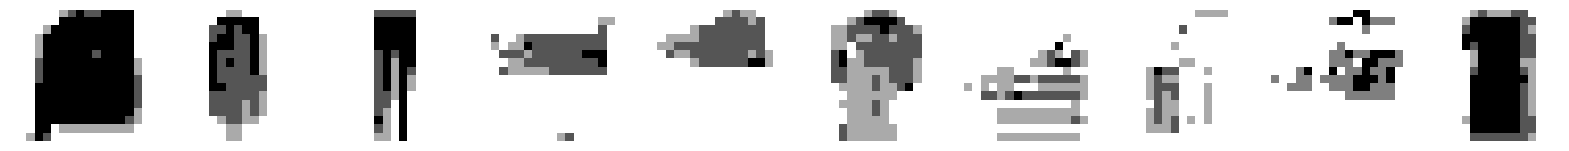

469/469 [==============================] - 19s 40ms/step - loss: 0.3299
Epoch 84/150
469/469 [==============================] - ETA: 0s - loss: 0.3298
Saved to 05_02_pixelcnn/output/generated_img_083.png


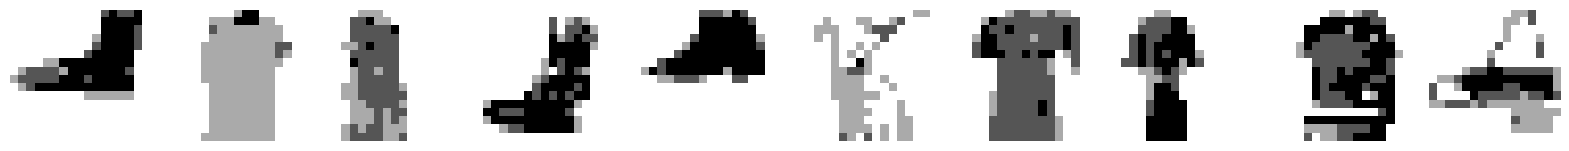

469/469 [==============================] - 19s 40ms/step - loss: 0.3298
Epoch 85/150
469/469 [==============================] - ETA: 0s - loss: 0.3297
Saved to 05_02_pixelcnn/output/generated_img_084.png


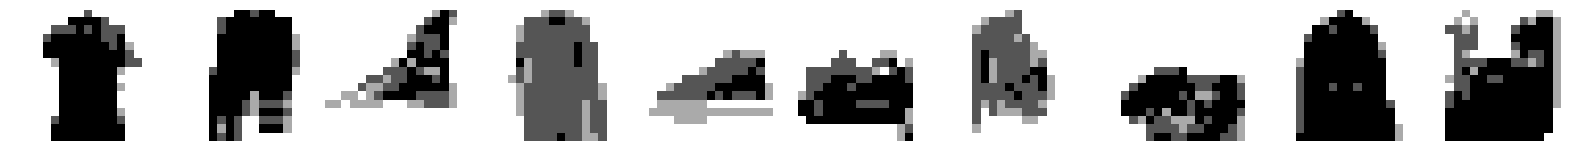

469/469 [==============================] - 19s 40ms/step - loss: 0.3297
Epoch 86/150
469/469 [==============================] - ETA: 0s - loss: 0.3295
Saved to 05_02_pixelcnn/output/generated_img_085.png


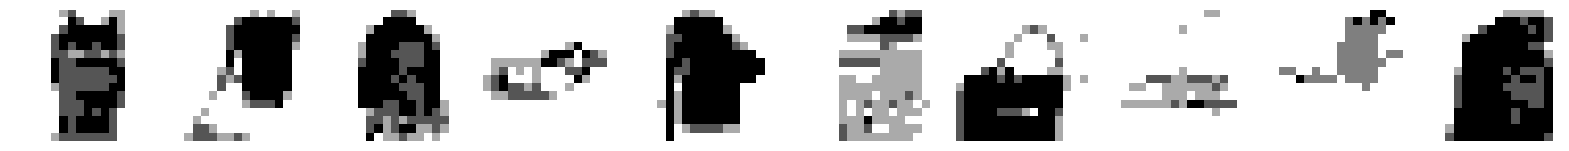

469/469 [==============================] - 19s 40ms/step - loss: 0.3295
Epoch 87/150
467/469 [============================>.] - ETA: 0s - loss: 0.3295
Saved to 05_02_pixelcnn/output/generated_img_086.png


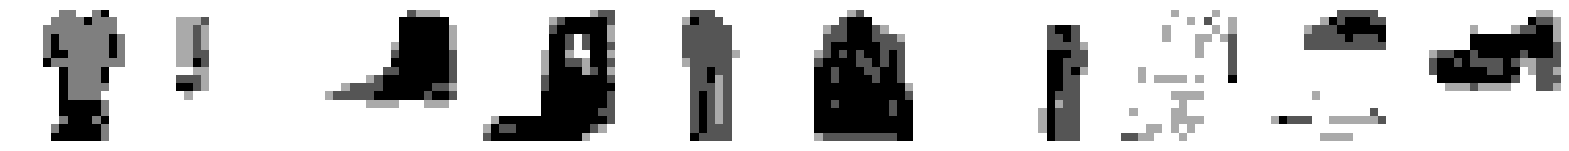

469/469 [==============================] - 18s 39ms/step - loss: 0.3295
Epoch 88/150
468/469 [============================>.] - ETA: 0s - loss: 0.3292
Saved to 05_02_pixelcnn/output/generated_img_087.png


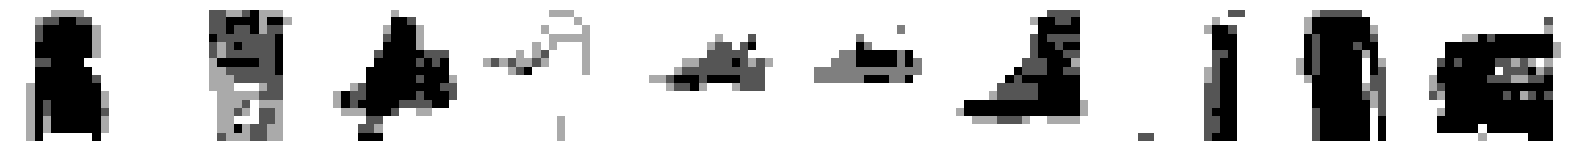

469/469 [==============================] - 19s 41ms/step - loss: 0.3291
Epoch 89/150
469/469 [==============================] - ETA: 0s - loss: 0.3292
Saved to 05_02_pixelcnn/output/generated_img_088.png


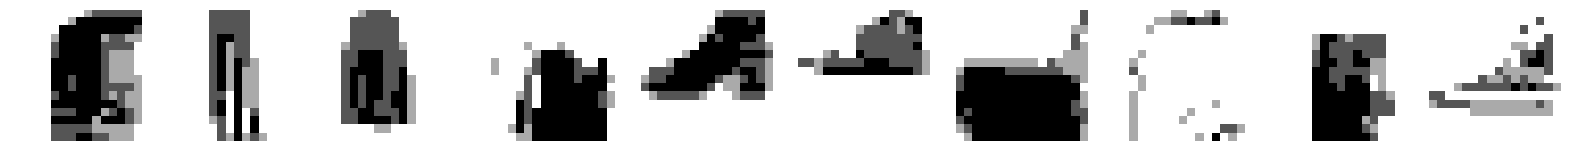

469/469 [==============================] - 18s 39ms/step - loss: 0.3292
Epoch 90/150
469/469 [==============================] - ETA: 0s - loss: 0.3292
Saved to 05_02_pixelcnn/output/generated_img_089.png


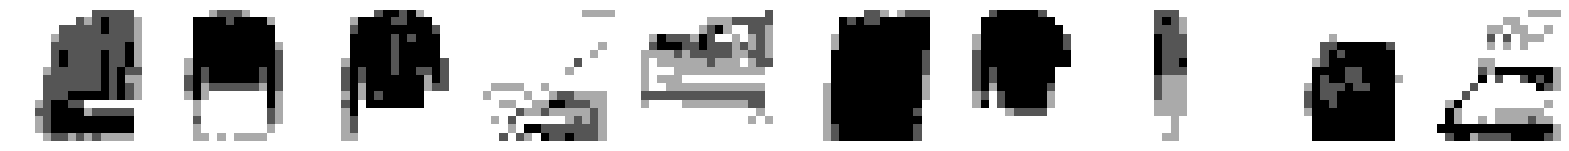

469/469 [==============================] - 19s 40ms/step - loss: 0.3292
Epoch 91/150
469/469 [==============================] - ETA: 0s - loss: 0.3289
Saved to 05_02_pixelcnn/output/generated_img_090.png


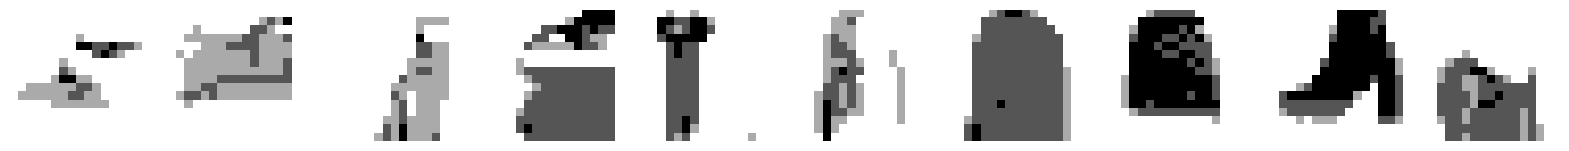

469/469 [==============================] - 19s 40ms/step - loss: 0.3289
Epoch 92/150
468/469 [============================>.] - ETA: 0s - loss: 0.3287
Saved to 05_02_pixelcnn/output/generated_img_091.png


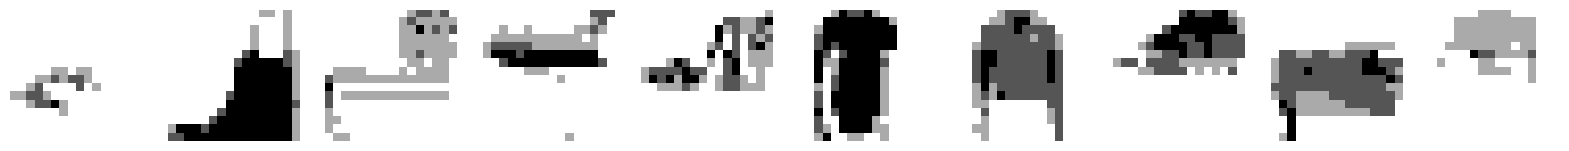

469/469 [==============================] - 19s 40ms/step - loss: 0.3287
Epoch 93/150
469/469 [==============================] - ETA: 0s - loss: 0.3286
Saved to 05_02_pixelcnn/output/generated_img_092.png


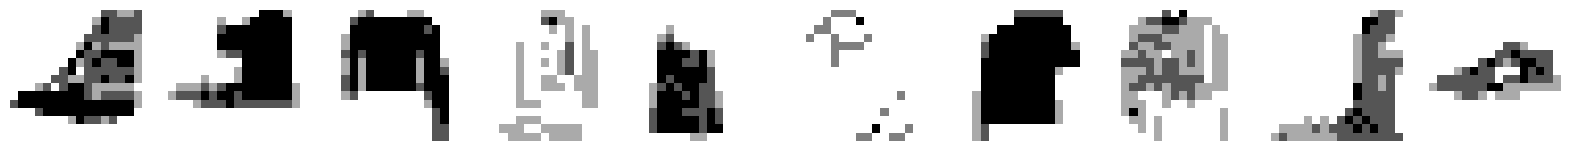

469/469 [==============================] - 19s 40ms/step - loss: 0.3286
Epoch 94/150
469/469 [==============================] - ETA: 0s - loss: 0.3286
Saved to 05_02_pixelcnn/output/generated_img_093.png


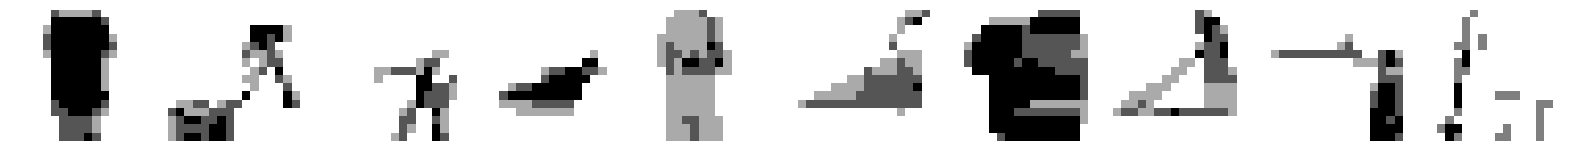

469/469 [==============================] - 19s 40ms/step - loss: 0.3286
Epoch 95/150
469/469 [==============================] - ETA: 0s - loss: 0.3284
Saved to 05_02_pixelcnn/output/generated_img_094.png


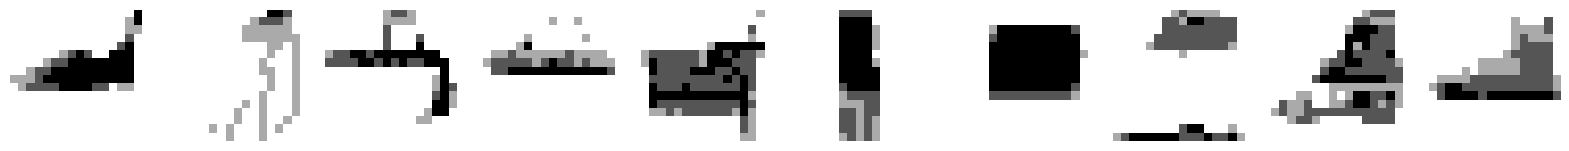

469/469 [==============================] - 19s 40ms/step - loss: 0.3284
Epoch 96/150
469/469 [==============================] - ETA: 0s - loss: 0.3283
Saved to 05_02_pixelcnn/output/generated_img_095.png


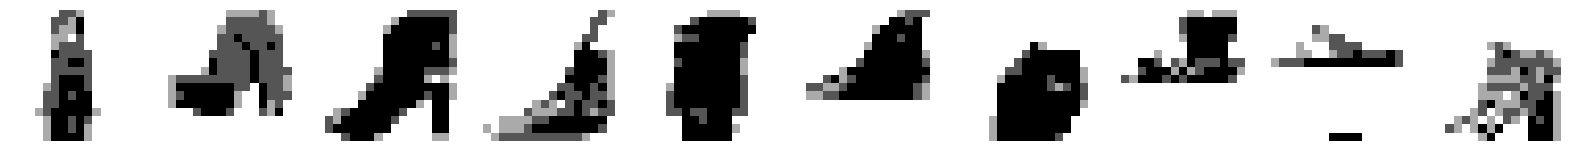

469/469 [==============================] - 19s 40ms/step - loss: 0.3283
Epoch 97/150
468/469 [============================>.] - ETA: 0s - loss: 0.3282
Saved to 05_02_pixelcnn/output/generated_img_096.png


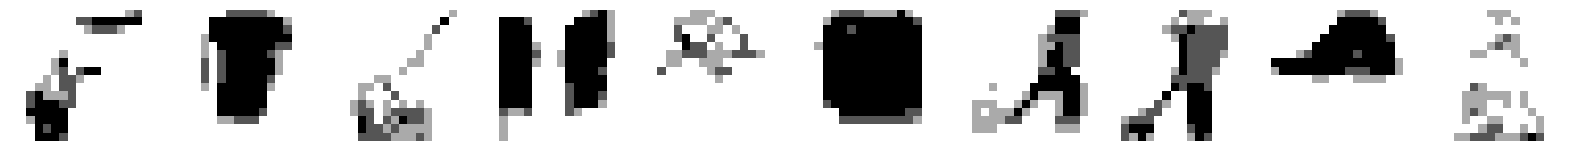

469/469 [==============================] - 19s 40ms/step - loss: 0.3282
Epoch 98/150
469/469 [==============================] - ETA: 0s - loss: 0.3281
Saved to 05_02_pixelcnn/output/generated_img_097.png


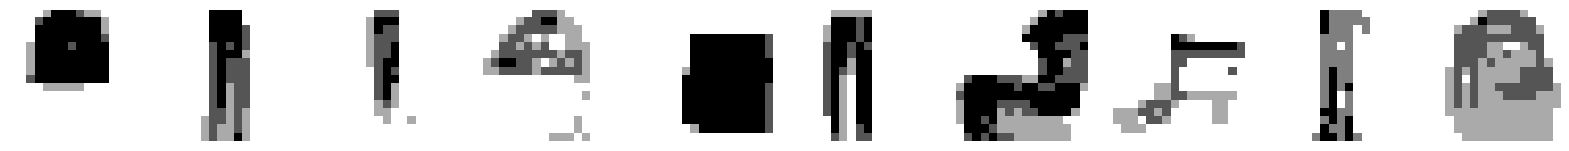

469/469 [==============================] - 19s 40ms/step - loss: 0.3281
Epoch 99/150
469/469 [==============================] - ETA: 0s - loss: 0.3279
Saved to 05_02_pixelcnn/output/generated_img_098.png


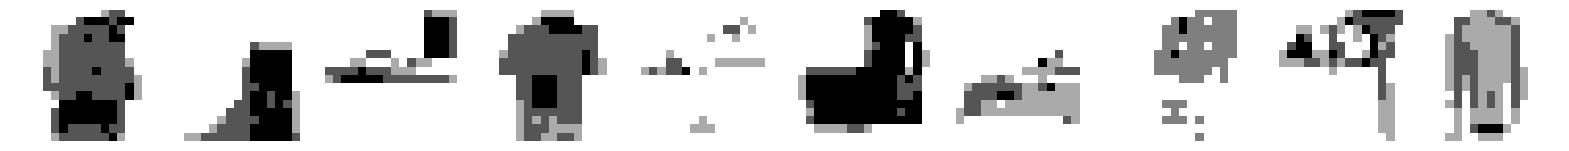

469/469 [==============================] - 19s 40ms/step - loss: 0.3279
Epoch 100/150
468/469 [============================>.] - ETA: 0s - loss: 0.3279
Saved to 05_02_pixelcnn/output/generated_img_099.png


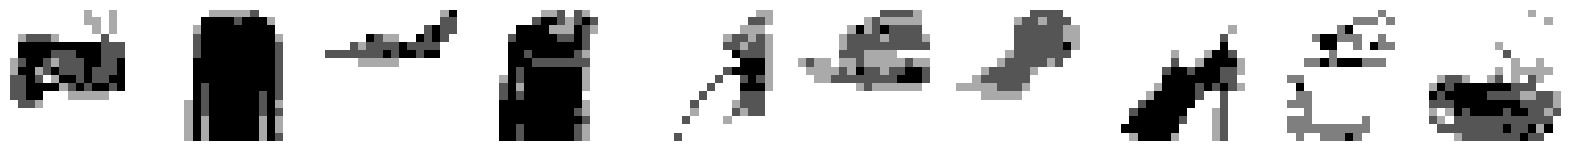

469/469 [==============================] - 19s 40ms/step - loss: 0.3279
Epoch 101/150
468/469 [============================>.] - ETA: 0s - loss: 0.3278
Saved to 05_02_pixelcnn/output/generated_img_100.png


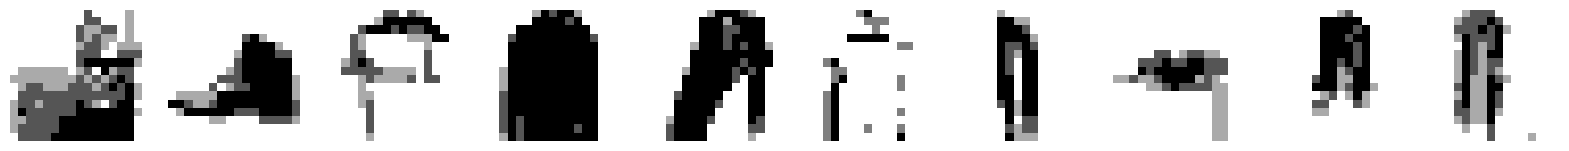

469/469 [==============================] - 19s 40ms/step - loss: 0.3278
Epoch 102/150
469/469 [==============================] - ETA: 0s - loss: 0.3276
Saved to 05_02_pixelcnn/output/generated_img_101.png


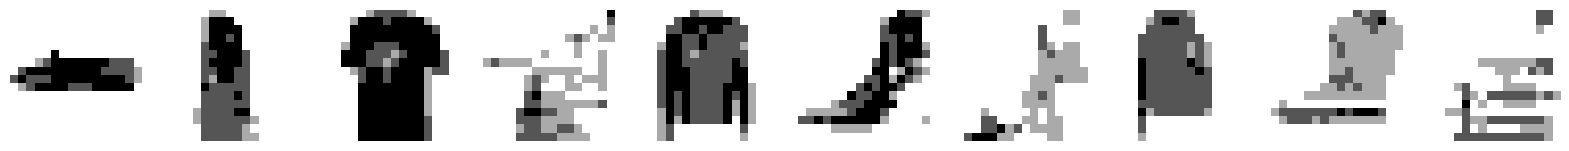

469/469 [==============================] - 19s 41ms/step - loss: 0.3276
Epoch 103/150
469/469 [==============================] - ETA: 0s - loss: 0.3276
Saved to 05_02_pixelcnn/output/generated_img_102.png


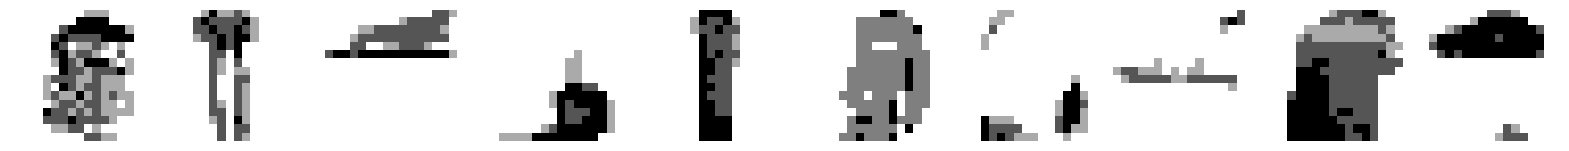

469/469 [==============================] - 19s 40ms/step - loss: 0.3276
Epoch 104/150
469/469 [==============================] - ETA: 0s - loss: 0.3274
Saved to 05_02_pixelcnn/output/generated_img_103.png


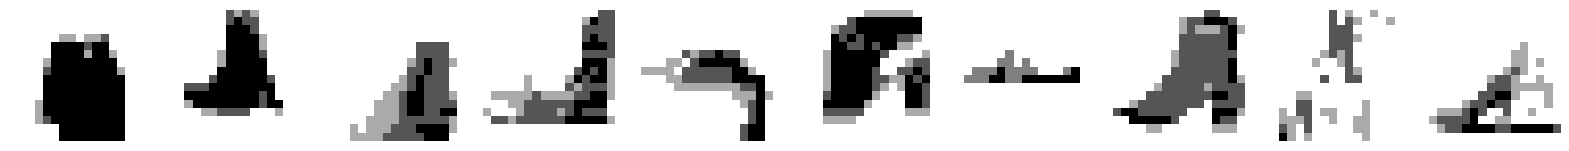

469/469 [==============================] - 19s 40ms/step - loss: 0.3274
Epoch 105/150
468/469 [============================>.] - ETA: 0s - loss: 0.3274
Saved to 05_02_pixelcnn/output/generated_img_104.png


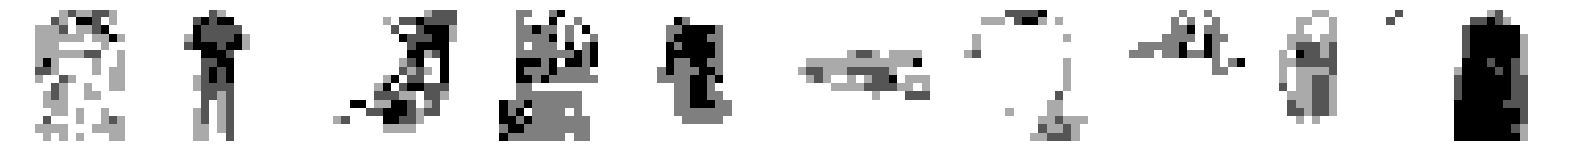

469/469 [==============================] - 19s 40ms/step - loss: 0.3274
Epoch 106/150
469/469 [==============================] - ETA: 0s - loss: 0.3273
Saved to 05_02_pixelcnn/output/generated_img_105.png


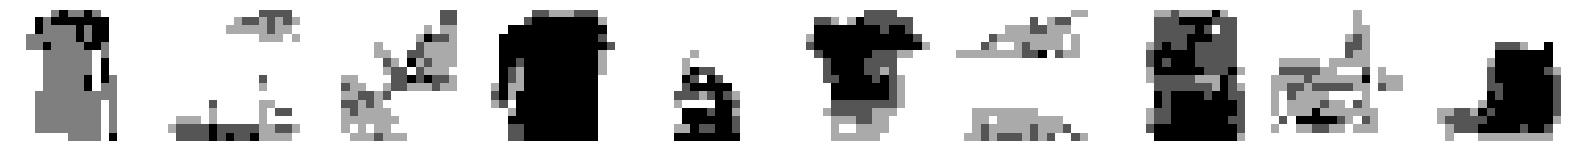

469/469 [==============================] - 19s 40ms/step - loss: 0.3273
Epoch 107/150
469/469 [==============================] - ETA: 0s - loss: 0.3271
Saved to 05_02_pixelcnn/output/generated_img_106.png


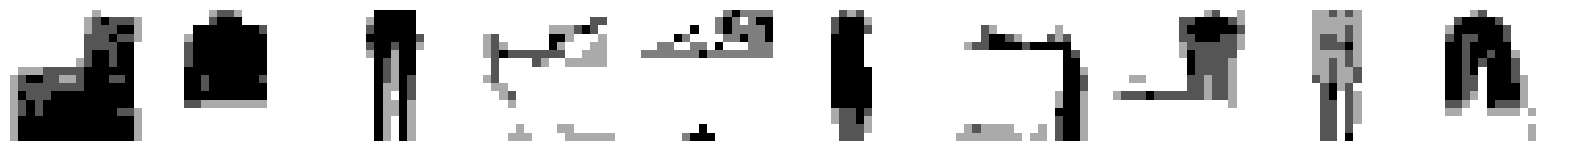

469/469 [==============================] - 19s 40ms/step - loss: 0.3271
Epoch 108/150
469/469 [==============================] - ETA: 0s - loss: 0.3272
Saved to 05_02_pixelcnn/output/generated_img_107.png


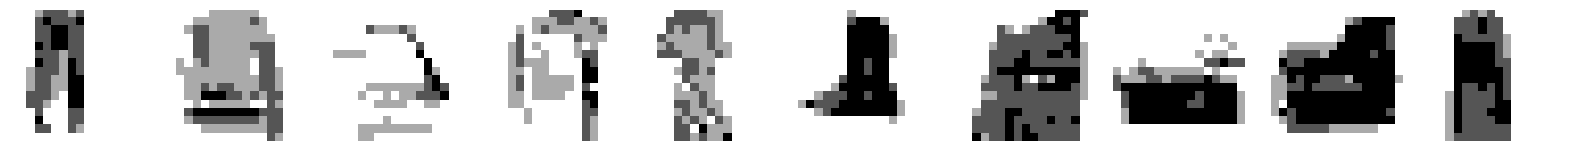

469/469 [==============================] - 19s 40ms/step - loss: 0.3272
Epoch 109/150
469/469 [==============================] - ETA: 0s - loss: 0.3270
Saved to 05_02_pixelcnn/output/generated_img_108.png


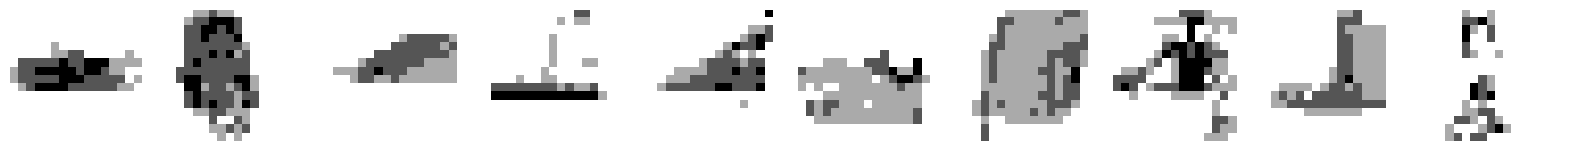

469/469 [==============================] - 19s 40ms/step - loss: 0.3270
Epoch 110/150
469/469 [==============================] - ETA: 0s - loss: 0.3269
Saved to 05_02_pixelcnn/output/generated_img_109.png


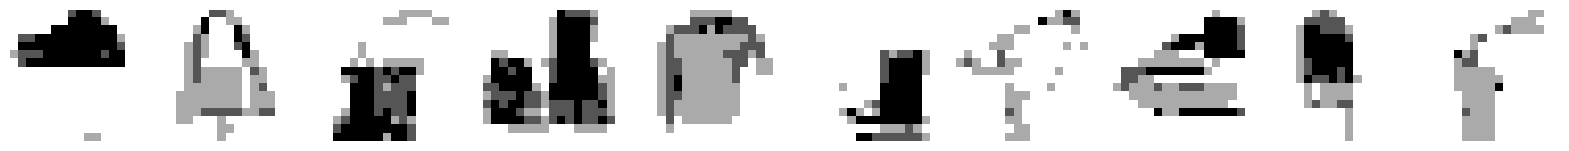

469/469 [==============================] - 19s 40ms/step - loss: 0.3269
Epoch 111/150
469/469 [==============================] - ETA: 0s - loss: 0.3268
Saved to 05_02_pixelcnn/output/generated_img_110.png


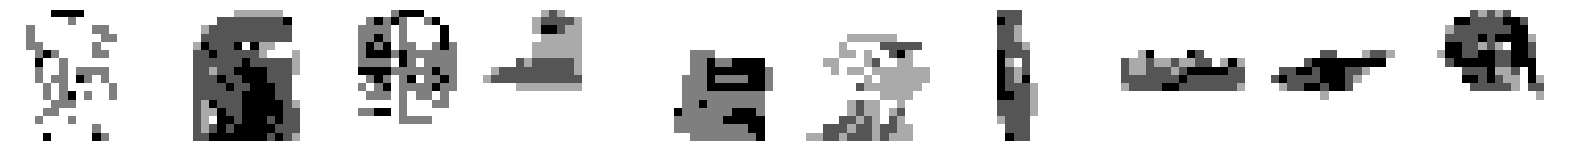

469/469 [==============================] - 19s 40ms/step - loss: 0.3268
Epoch 112/150
469/469 [==============================] - ETA: 0s - loss: 0.3265
Saved to 05_02_pixelcnn/output/generated_img_111.png


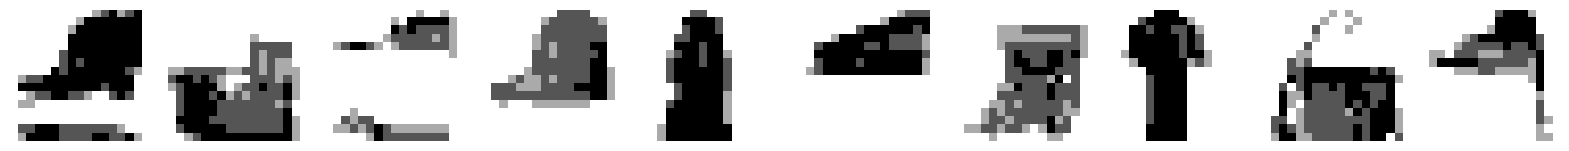

469/469 [==============================] - 19s 40ms/step - loss: 0.3265
Epoch 113/150
468/469 [============================>.] - ETA: 0s - loss: 0.3265
Saved to 05_02_pixelcnn/output/generated_img_112.png


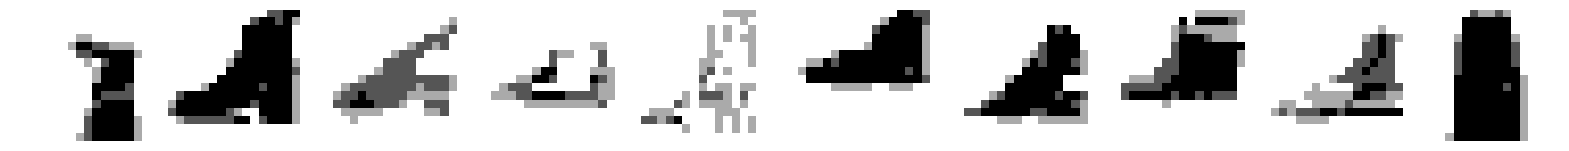

469/469 [==============================] - 19s 40ms/step - loss: 0.3265
Epoch 114/150
469/469 [==============================] - ETA: 0s - loss: 0.3267
Saved to 05_02_pixelcnn/output/generated_img_113.png


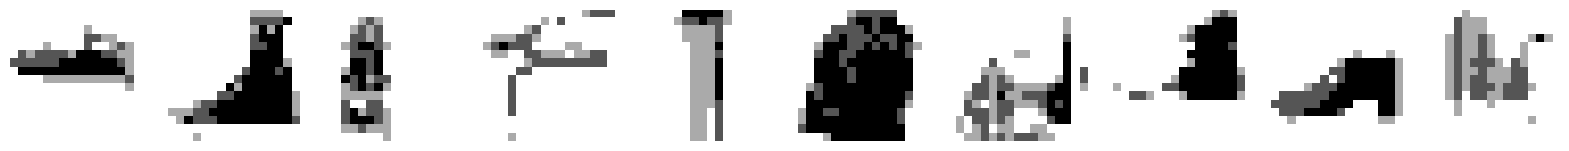

469/469 [==============================] - 18s 39ms/step - loss: 0.3267
Epoch 115/150
469/469 [==============================] - ETA: 0s - loss: 0.3264
Saved to 05_02_pixelcnn/output/generated_img_114.png


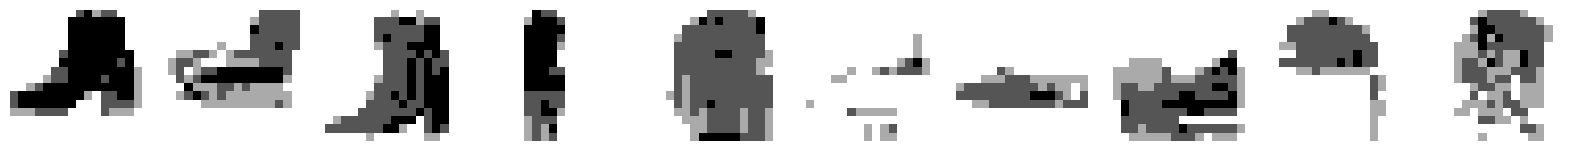

469/469 [==============================] - 19s 40ms/step - loss: 0.3264
Epoch 116/150
469/469 [==============================] - ETA: 0s - loss: 0.3264
Saved to 05_02_pixelcnn/output/generated_img_115.png


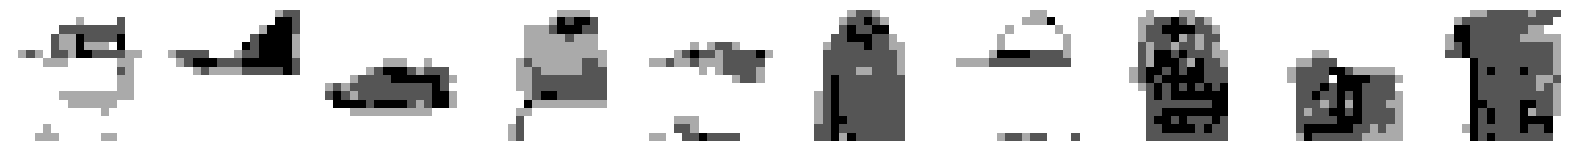

469/469 [==============================] - 19s 40ms/step - loss: 0.3264
Epoch 117/150
469/469 [==============================] - ETA: 0s - loss: 0.3264
Saved to 05_02_pixelcnn/output/generated_img_116.png


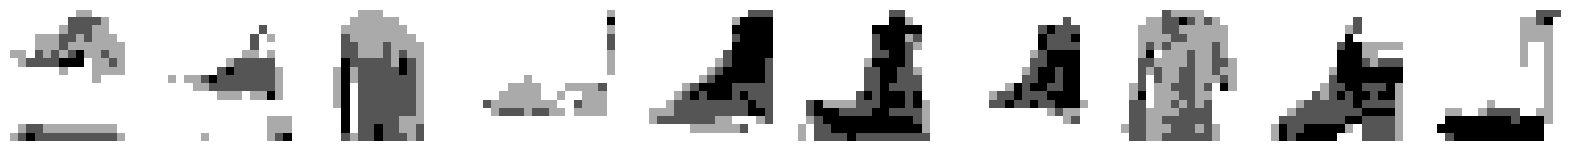

469/469 [==============================] - 19s 40ms/step - loss: 0.3264
Epoch 118/150
469/469 [==============================] - ETA: 0s - loss: 0.3261
Saved to 05_02_pixelcnn/output/generated_img_117.png


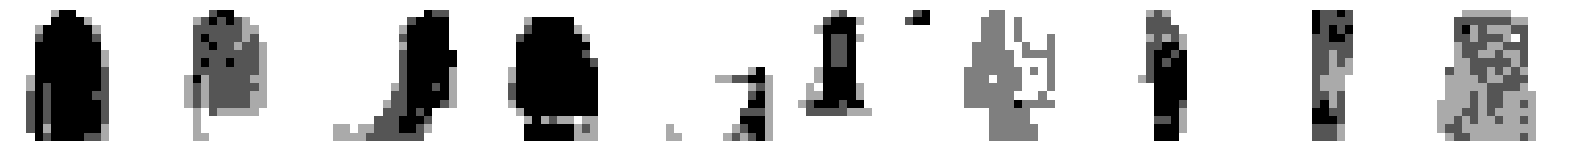

469/469 [==============================] - 19s 40ms/step - loss: 0.3261
Epoch 119/150
467/469 [============================>.] - ETA: 0s - loss: 0.3260
Saved to 05_02_pixelcnn/output/generated_img_118.png


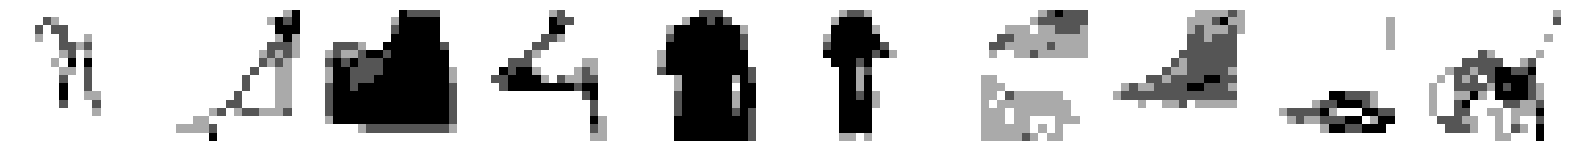

469/469 [==============================] - 19s 40ms/step - loss: 0.3260
Epoch 120/150
469/469 [==============================] - ETA: 0s - loss: 0.3260
Saved to 05_02_pixelcnn/output/generated_img_119.png


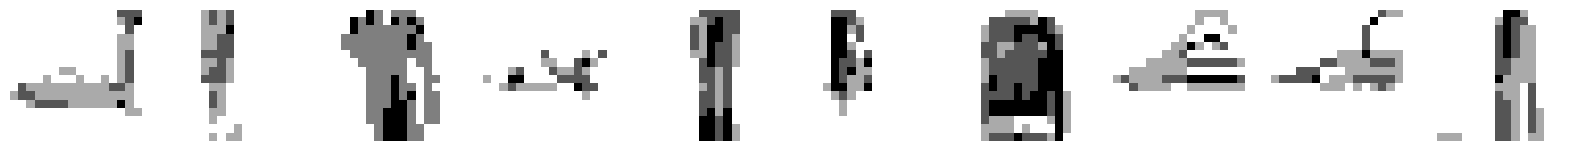

469/469 [==============================] - 18s 39ms/step - loss: 0.3260
Epoch 121/150
469/469 [==============================] - ETA: 0s - loss: 0.3259
Saved to 05_02_pixelcnn/output/generated_img_120.png


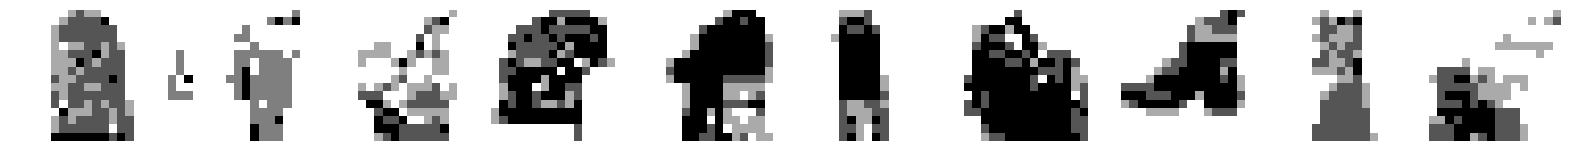

469/469 [==============================] - 19s 41ms/step - loss: 0.3259
Epoch 122/150
469/469 [==============================] - ETA: 0s - loss: 0.3258
Saved to 05_02_pixelcnn/output/generated_img_121.png


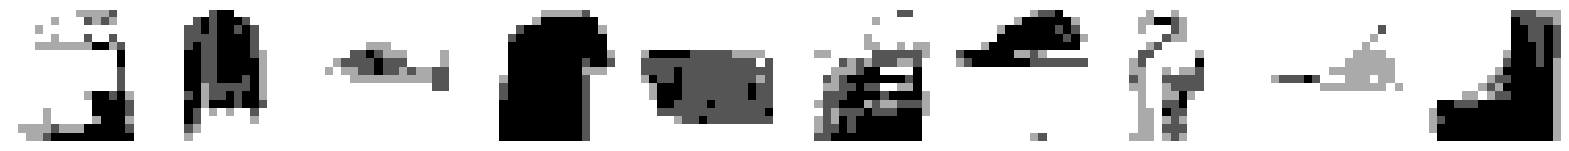

469/469 [==============================] - 18s 39ms/step - loss: 0.3258
Epoch 123/150
469/469 [==============================] - ETA: 0s - loss: 0.3258
Saved to 05_02_pixelcnn/output/generated_img_122.png


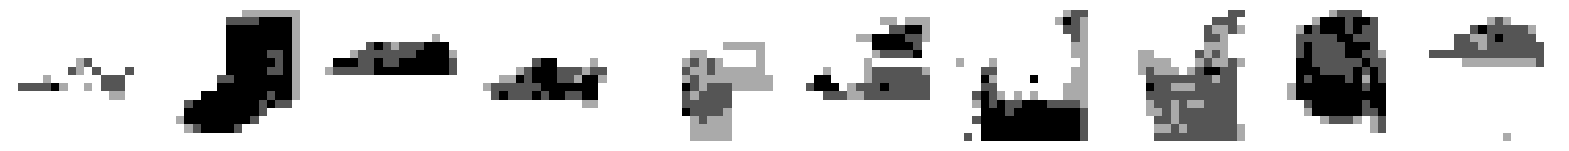

469/469 [==============================] - 19s 40ms/step - loss: 0.3258
Epoch 124/150
469/469 [==============================] - ETA: 0s - loss: 0.3257
Saved to 05_02_pixelcnn/output/generated_img_123.png


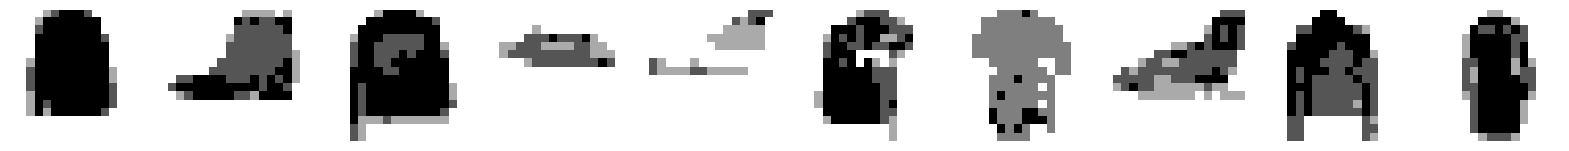

469/469 [==============================] - 18s 39ms/step - loss: 0.3257
Epoch 125/150
468/469 [============================>.] - ETA: 0s - loss: 0.3256
Saved to 05_02_pixelcnn/output/generated_img_124.png


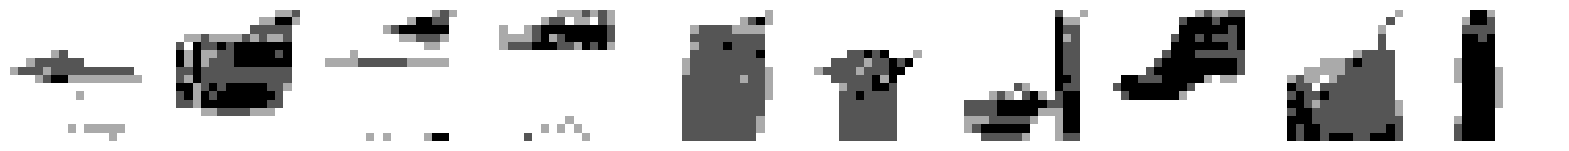

469/469 [==============================] - 19s 40ms/step - loss: 0.3256
Epoch 126/150
469/469 [==============================] - ETA: 0s - loss: 0.3255
Saved to 05_02_pixelcnn/output/generated_img_125.png


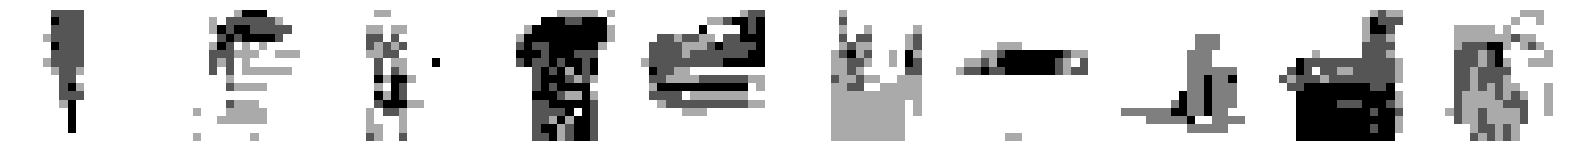

469/469 [==============================] - 18s 39ms/step - loss: 0.3255
Epoch 127/150
469/469 [==============================] - ETA: 0s - loss: 0.3253
Saved to 05_02_pixelcnn/output/generated_img_126.png


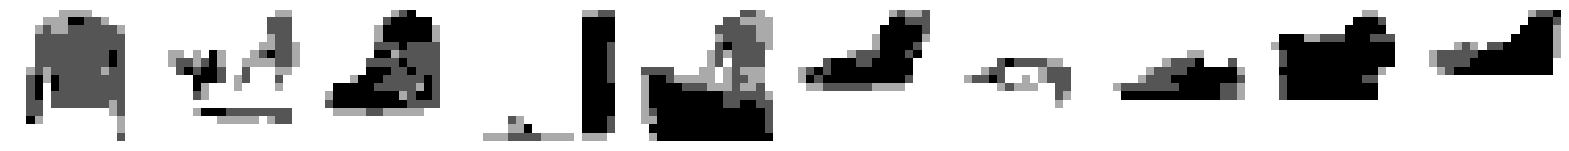

469/469 [==============================] - 19s 40ms/step - loss: 0.3253
Epoch 128/150
469/469 [==============================] - ETA: 0s - loss: 0.3253
Saved to 05_02_pixelcnn/output/generated_img_127.png


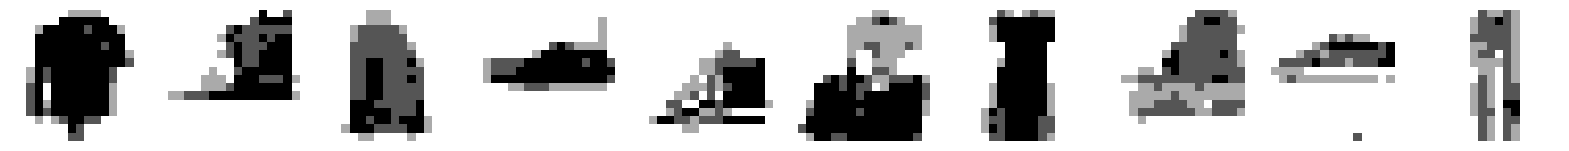

469/469 [==============================] - 18s 39ms/step - loss: 0.3253
Epoch 129/150
469/469 [==============================] - ETA: 0s - loss: 0.3253
Saved to 05_02_pixelcnn/output/generated_img_128.png


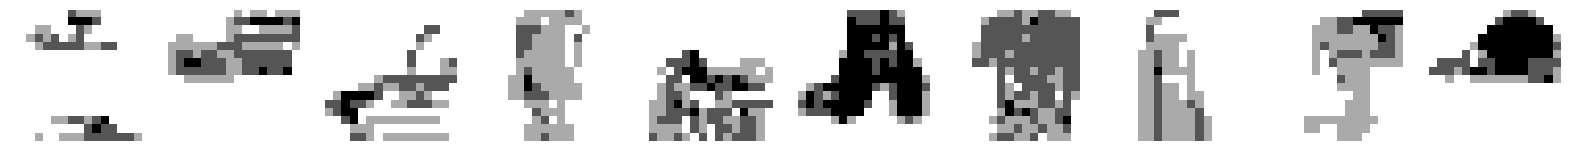

469/469 [==============================] - 19s 40ms/step - loss: 0.3253
Epoch 130/150
469/469 [==============================] - ETA: 0s - loss: 0.3253
Saved to 05_02_pixelcnn/output/generated_img_129.png


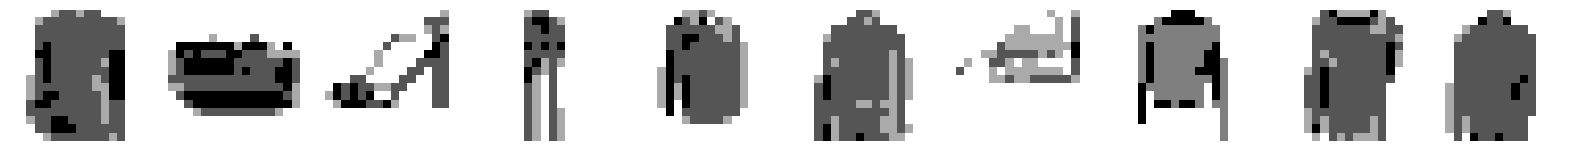

469/469 [==============================] - 19s 40ms/step - loss: 0.3253
Epoch 131/150
469/469 [==============================] - ETA: 0s - loss: 0.3251
Saved to 05_02_pixelcnn/output/generated_img_130.png


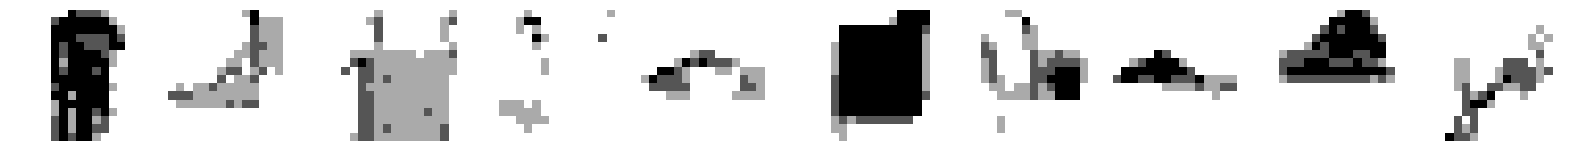

469/469 [==============================] - 19s 40ms/step - loss: 0.3251
Epoch 132/150
469/469 [==============================] - ETA: 0s - loss: 0.3252
Saved to 05_02_pixelcnn/output/generated_img_131.png


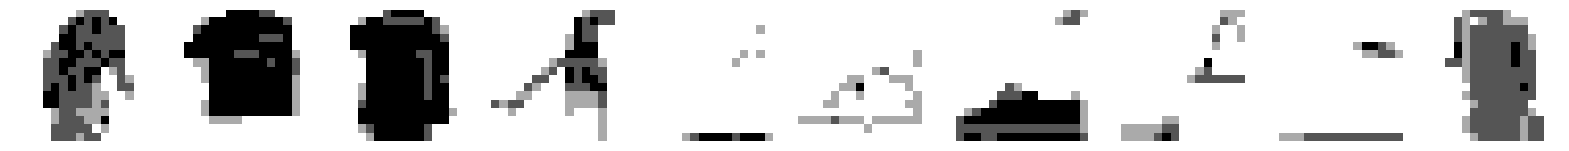

469/469 [==============================] - 18s 39ms/step - loss: 0.3252
Epoch 133/150
469/469 [==============================] - ETA: 0s - loss: 0.3252
Saved to 05_02_pixelcnn/output/generated_img_132.png


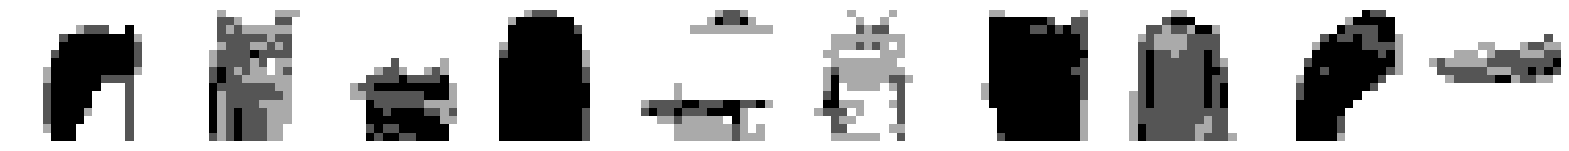

469/469 [==============================] - 19s 40ms/step - loss: 0.3252
Epoch 134/150
469/469 [==============================] - ETA: 0s - loss: 0.3249
Saved to 05_02_pixelcnn/output/generated_img_133.png


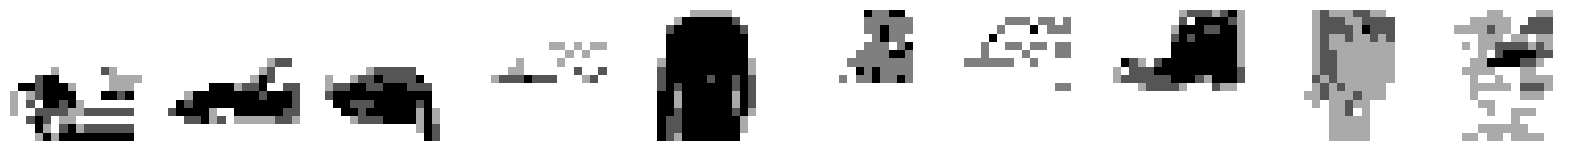

469/469 [==============================] - 18s 39ms/step - loss: 0.3249
Epoch 135/150
468/469 [============================>.] - ETA: 0s - loss: 0.3247
Saved to 05_02_pixelcnn/output/generated_img_134.png


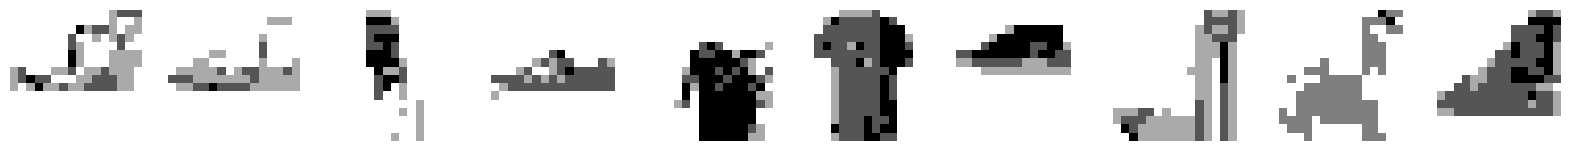

469/469 [==============================] - 19s 40ms/step - loss: 0.3247
Epoch 136/150
469/469 [==============================] - ETA: 0s - loss: 0.3247
Saved to 05_02_pixelcnn/output/generated_img_135.png


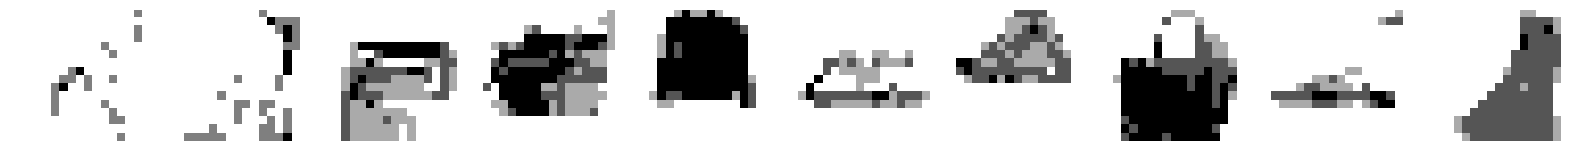

469/469 [==============================] - 18s 39ms/step - loss: 0.3247
Epoch 137/150
469/469 [==============================] - ETA: 0s - loss: 0.3247
Saved to 05_02_pixelcnn/output/generated_img_136.png


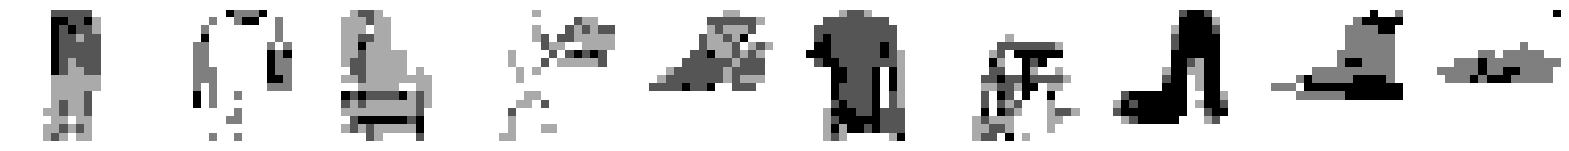

469/469 [==============================] - 19s 40ms/step - loss: 0.3247
Epoch 138/150
469/469 [==============================] - ETA: 0s - loss: 0.3247
Saved to 05_02_pixelcnn/output/generated_img_137.png


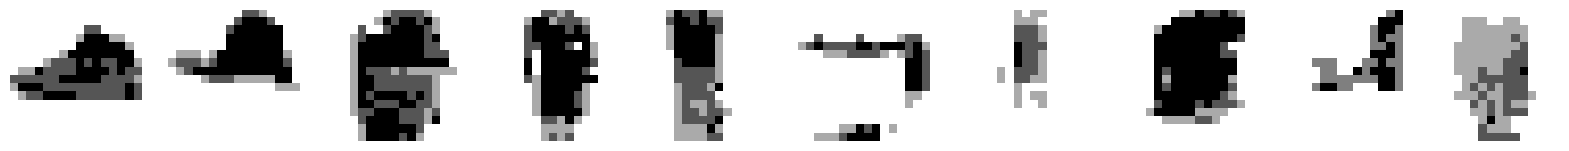

469/469 [==============================] - 19s 40ms/step - loss: 0.3247
Epoch 139/150
468/469 [============================>.] - ETA: 0s - loss: 0.3246
Saved to 05_02_pixelcnn/output/generated_img_138.png


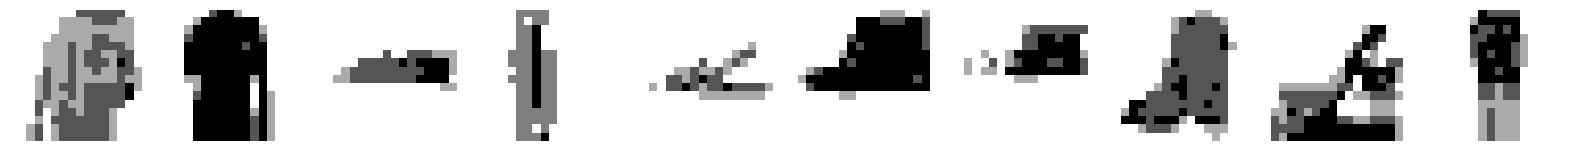

469/469 [==============================] - 19s 40ms/step - loss: 0.3245
Epoch 140/150
469/469 [==============================] - ETA: 0s - loss: 0.3245
Saved to 05_02_pixelcnn/output/generated_img_139.png


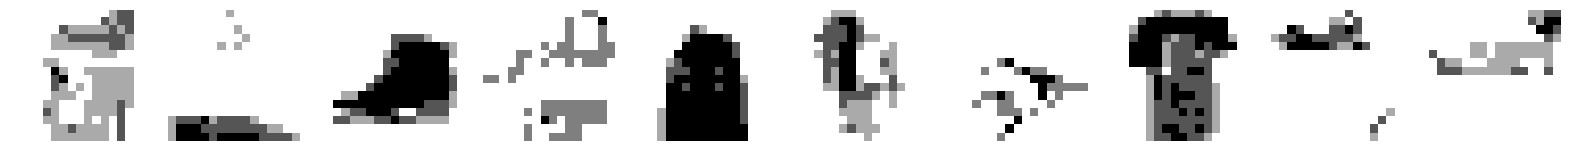

469/469 [==============================] - 19s 40ms/step - loss: 0.3245
Epoch 141/150
469/469 [==============================] - ETA: 0s - loss: 0.3245
Saved to 05_02_pixelcnn/output/generated_img_140.png


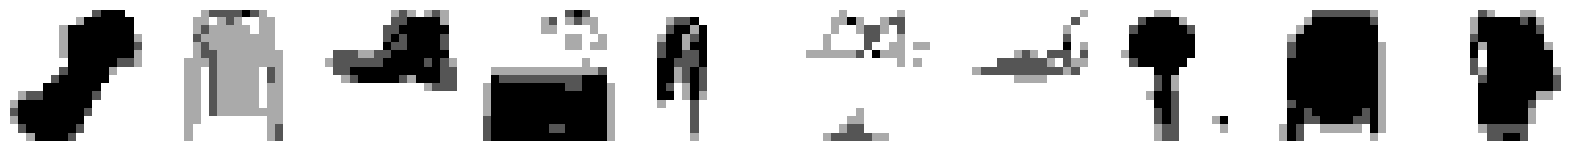

469/469 [==============================] - 19s 40ms/step - loss: 0.3245
Epoch 142/150
468/469 [============================>.] - ETA: 0s - loss: 0.3243
Saved to 05_02_pixelcnn/output/generated_img_141.png


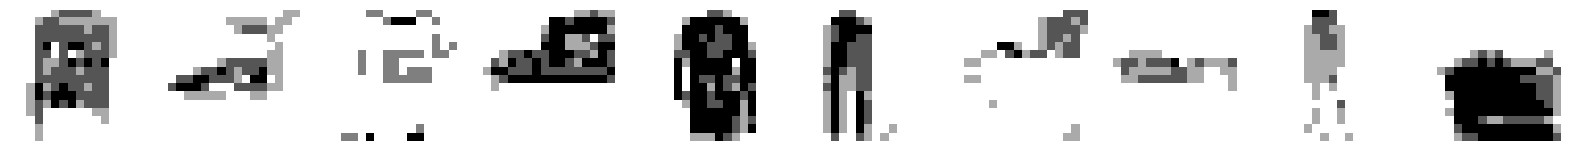

469/469 [==============================] - 19s 40ms/step - loss: 0.3243
Epoch 143/150
468/469 [============================>.] - ETA: 0s - loss: 0.3242
Saved to 05_02_pixelcnn/output/generated_img_142.png


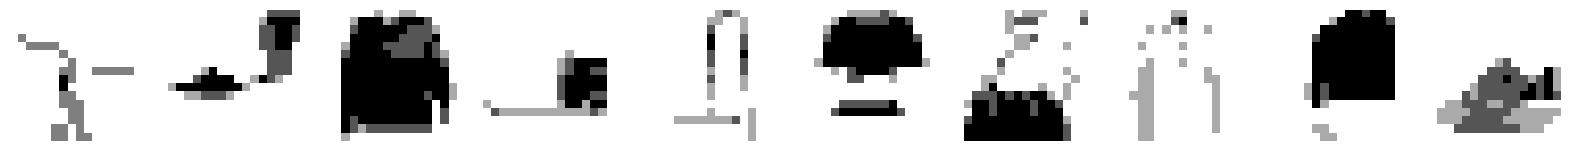

469/469 [==============================] - 19s 40ms/step - loss: 0.3242
Epoch 144/150
469/469 [==============================] - ETA: 0s - loss: 0.3243
Saved to 05_02_pixelcnn/output/generated_img_143.png


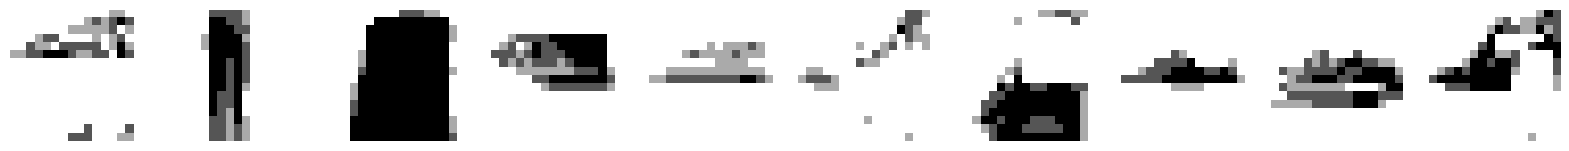

469/469 [==============================] - 19s 40ms/step - loss: 0.3243
Epoch 145/150
468/469 [============================>.] - ETA: 0s - loss: 0.3240
Saved to 05_02_pixelcnn/output/generated_img_144.png


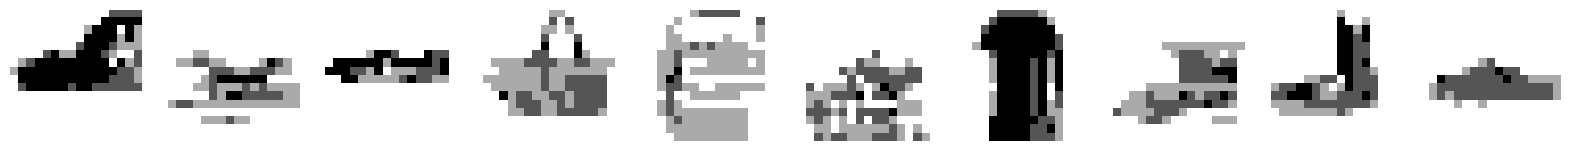

469/469 [==============================] - 19s 40ms/step - loss: 0.3240
Epoch 146/150
469/469 [==============================] - ETA: 0s - loss: 0.3241
Saved to 05_02_pixelcnn/output/generated_img_145.png


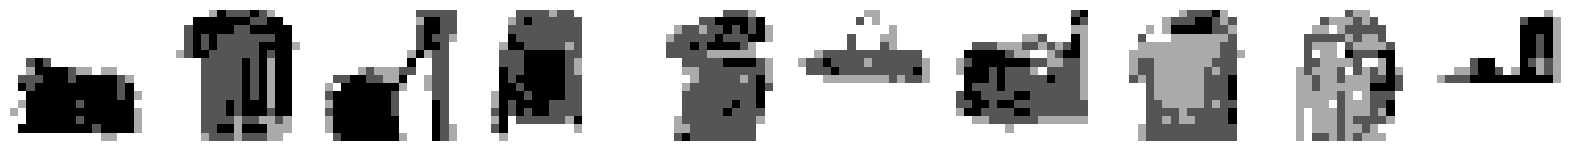

469/469 [==============================] - 19s 39ms/step - loss: 0.3241
Epoch 147/150
468/469 [============================>.] - ETA: 0s - loss: 0.3242
Saved to 05_02_pixelcnn/output/generated_img_146.png


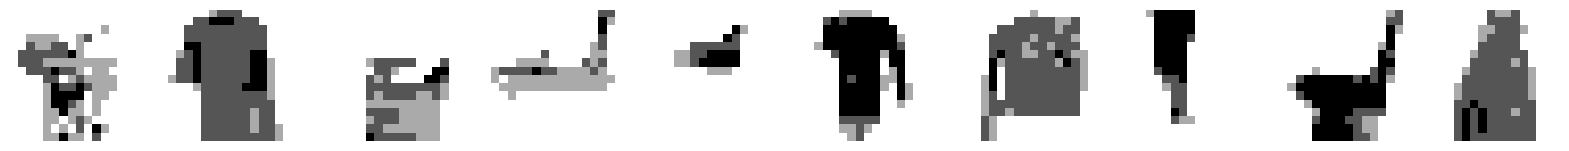

469/469 [==============================] - 19s 40ms/step - loss: 0.3241
Epoch 148/150
469/469 [==============================] - ETA: 0s - loss: 0.3240
Saved to 05_02_pixelcnn/output/generated_img_147.png


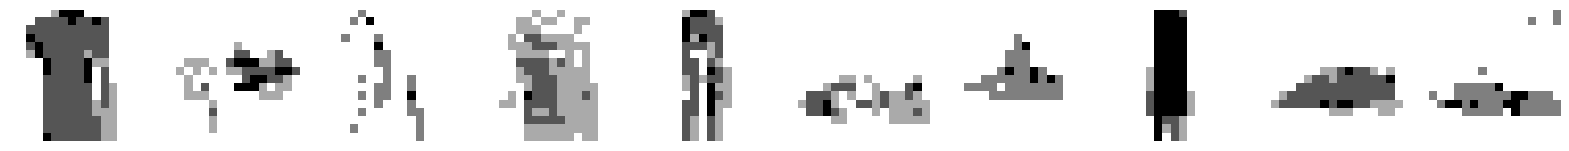

469/469 [==============================] - 18s 39ms/step - loss: 0.3240
Epoch 149/150
469/469 [==============================] - ETA: 0s - loss: 0.3239
Saved to 05_02_pixelcnn/output/generated_img_148.png


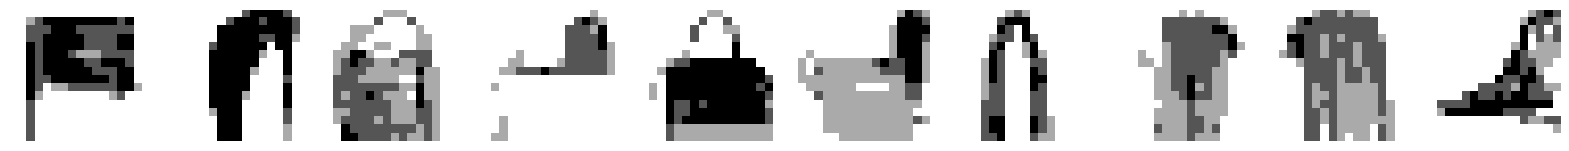

469/469 [==============================] - 19s 40ms/step - loss: 0.3239
Epoch 150/150
469/469 [==============================] - ETA: 0s - loss: 0.3239
Saved to 05_02_pixelcnn/output/generated_img_149.png


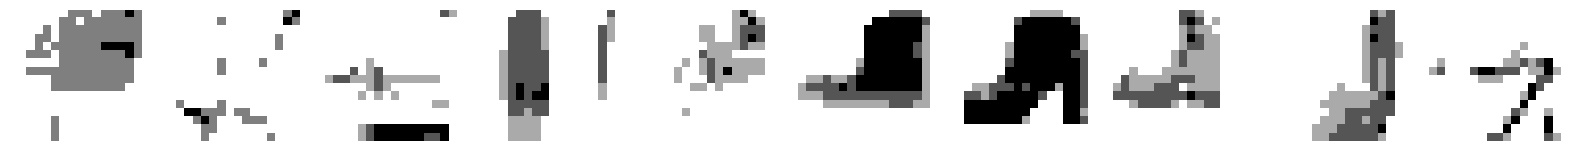

469/469 [==============================] - 19s 40ms/step - loss: 0.3239
CPU times: user 42min 16s, sys: 1min 11s, total: 43min 27s
Wall time: 46min 51s


In [12]:
%%time
pixel_cnn.fit(
    input_data,
    output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[tensorboard_callback, img_generator_callback],
)

## 4. Generate images <a name="generate"></a>

In [13]:
generated_images = img_generator_callback.generate(temperature=1.0)

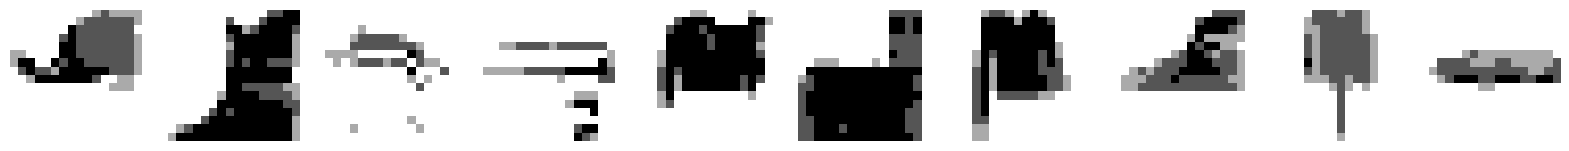

In [14]:
display(generated_images)

In [15]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Friday, June 02, 2023
# Run Time: 00:47:04
